In [1]:
import os
import pandas as pd
import numpy as np
import dataframe as df
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from torchmetrics.functional import accuracy

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
X_train = pd.read_csv('../data2.csv')

In [3]:
X_train.head()

,time,id,group,state,HEOL,HEOR,FP1,FP2,VEOU,VEOL,...,P4,T6,A2,O1,OZ,O2,FT9,FT10,PO1,PO2
0,0,0,0,Fatigue,1.215492e-13,-4.869703e-17,-6.140989e-14,2.598510e-17,-1.160435e-13,-3.167843e-17,...,1.651714e-13,-3.307430e-17,3.455894e-13,-6.391263e-17,8.724439e-14,-3.155565e-17,-7.326835e-14,-3.155565e-17,4.404571e-14,-2.665396e-17
1,1,1,0,Fatigue,-7.831237e+01,-1.362717e-02,-5.690807e+01,-4.192949e-02,3.212726e+02,-1.397650e-02,...,-2.646920e+02,-6.988248e-03,-2.281396e+02,4.192949e-02,-5.818660e+01,3.494124e-02,1.040445e+02,3.494124e-02,-3.291532e+01,2.795299e-02
2,2,2,0,Fatigue,-1.533161e+02,-2.671759e-02,-1.114424e+02,-8.209756e-02,6.290321e+02,-2.736585e-02,...,-5.183021e+02,-1.368293e-02,-4.459774e+02,8.209756e-02,-1.138533e+02,6.841464e-02,2.037677e+02,6.841464e-02,-6.439023e+01,5.473171e-02
3,3,3,0,Fatigue,-2.219502e+02,-3.877185e-02,-1.614074e+02,-1.188756e-01,9.107824e+02,-3.962519e-02,...,-7.505852e+02,-1.981260e-02,-6.440388e+02,1.188756e-01,-1.646722e+02,9.906298e-02,2.951723e+02,9.906298e-02,-9.309419e+01,7.925038e-02
4,4,4,0,Fatigue,-2.816333e+02,-4.936209e-02,-2.049461e+02,-1.508884e-01,1.155975e+03,-5.029612e-02,...,-9.528851e+02,-2.514806e-02,-8.144362e+02,1.508884e-01,-2.086840e+02,1.257403e-01,3.748789e+02,1.257403e-01,-1.179092e+02,1.005922e-01


In [4]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(X_train.state)

label_encoder.classes_

array(['Fatigue', 'Normal'], dtype=object)

In [5]:
X_train['label'] = encoded_labels
X_train.head()

,time,id,group,state,HEOL,HEOR,FP1,FP2,VEOU,VEOL,...,T6,A2,O1,OZ,O2,FT9,FT10,PO1,PO2,label
0,0,0,0,Fatigue,1.215492e-13,-4.869703e-17,-6.140989e-14,2.598510e-17,-1.160435e-13,-3.167843e-17,...,-3.307430e-17,3.455894e-13,-6.391263e-17,8.724439e-14,-3.155565e-17,-7.326835e-14,-3.155565e-17,4.404571e-14,-2.665396e-17,0
1,1,1,0,Fatigue,-7.831237e+01,-1.362717e-02,-5.690807e+01,-4.192949e-02,3.212726e+02,-1.397650e-02,...,-6.988248e-03,-2.281396e+02,4.192949e-02,-5.818660e+01,3.494124e-02,1.040445e+02,3.494124e-02,-3.291532e+01,2.795299e-02,0
2,2,2,0,Fatigue,-1.533161e+02,-2.671759e-02,-1.114424e+02,-8.209756e-02,6.290321e+02,-2.736585e-02,...,-1.368293e-02,-4.459774e+02,8.209756e-02,-1.138533e+02,6.841464e-02,2.037677e+02,6.841464e-02,-6.439023e+01,5.473171e-02,0
3,3,3,0,Fatigue,-2.219502e+02,-3.877185e-02,-1.614074e+02,-1.188756e-01,9.107824e+02,-3.962519e-02,...,-1.981260e-02,-6.440388e+02,1.188756e-01,-1.646722e+02,9.906298e-02,2.951723e+02,9.906298e-02,-9.309419e+01,7.925038e-02,0
4,4,4,0,Fatigue,-2.816333e+02,-4.936209e-02,-2.049461e+02,-1.508884e-01,1.155975e+03,-5.029612e-02,...,-2.514806e-02,-8.144362e+02,1.508884e-01,-2.086840e+02,1.257403e-01,3.748789e+02,1.257403e-01,-1.179092e+02,1.005922e-01,0


In [6]:
FEATURE_COLUMNS = X_train.columns.tolist()[4:-2]

In [7]:
g = X_train.groupby("group")

In [8]:
sequences = [] 

for name, group in g:
    sequence_features = group[FEATURE_COLUMNS]
    label = group.label.iloc[0]
    
#     print((sequence_features, label))
    sequences.append((sequence_features, label))

In [9]:
sequences[0]

(              HEOL          HEOR           FP1           FP2          VEOU  \
 0     1.215492e-13 -4.869703e-17 -6.140989e-14  2.598510e-17 -1.160435e-13   
 1    -7.831237e+01 -1.362717e-02 -5.690807e+01 -4.192949e-02  3.212726e+02   
 2    -1.533161e+02 -2.671759e-02 -1.114424e+02 -8.209756e-02  6.290321e+02   
 3    -2.219502e+02 -3.877185e-02 -1.614074e+02 -1.188756e-01  9.107824e+02   
 4    -2.816333e+02 -4.936209e-02 -2.049461e+02 -1.508884e-01  1.155975e+03   
 ...            ...           ...           ...           ...           ...   
 1019  9.189533e+00  2.849707e-03  1.783298e+01  6.329993e-03 -4.930598e+01   
 1020  7.436606e+00  2.869100e-03  1.661349e+01  6.348566e-03 -5.123579e+01   
 1021  5.528420e+00  2.921818e-03  1.508811e+01  6.324462e-03 -5.286875e+01   
 1022  3.726376e+00  3.024905e-03  1.349644e+01  6.342777e-03 -5.465339e+01   
 1023  1.962049e+00  3.137497e-03  1.184765e+01  6.318416e-03 -5.574251e+01   
 
               VEOL            F7            F3   

In [10]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)
val_sequences, test_sequences = train_test_split(test_sequences, test_size=0.5)

In [11]:
len(train_sequences), len(val_sequences), len(test_sequences)

(11268, 1409, 1409)

## Data Set

In [12]:
class DrowsyDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).long()
        )

In [13]:
class DrowsyDataModule(pl.LightningDataModule):
    
    def __init__(self, train_sequences, val_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = DrowsyDataset(self.train_sequences)
        self.val_dataset = DrowsyDataset(self.val_sequences)
        self.test_dataset = DrowsyDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=os.cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=os.cpu_count()
        ) 

In [14]:
N_EPOCHS = 250
BATCH_SIZE = 200

data_module = DrowsyDataModule(train_sequences, val_sequences, test_sequences, BATCH_SIZE)

## Models

In [15]:
class DrowsyModel(nn.Module):
    
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        
        self.n_hidden = n_hidden
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )
        
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        return self.classifier(out)

In [16]:
class DrowsyPredictor(pl.LightningModule):
    
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = DrowsyModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x, label=None):
        output = self.model(x)
        loss = 0
        if label is not None:
            loss = self.criterion(output, label)
        return loss, output
        
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)
        
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)
        
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [17]:
model = DrowsyPredictor(
    n_features=len(FEATURE_COLUMNS), 
    n_classes=len(label_encoder.classes_)
)

In [18]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs --port=8888

In [19]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint250x250",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="Drowsy")

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    gpus=[0],
#     progress_bar_refresh_rate=20
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Training 

In [20]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | DrowsyModel      | 1.4 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.429     Total estimated model params size (MB)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /Workspace/code/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Epoch 0:  88%|████████▊ | 57/65 [00:42<00:05,  1.35it/s, loss=0.686, v_num=13, train_loss=0.686, train_accuracy=0.515]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 65/65 [00:46<00:00,  1.39it/s, loss=0.686, v_num=13, train_loss=0.686, train_accuracy=0.515, val_loss=0.684, val_accuracy=0.569]
                                                         

Epoch 0, global step 56: val_loss reached 0.68369 (best 0.68369), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 1:  89%|████████▉ | 58/65 [00:42<00:05,  1.37it/s, loss=0.629, v_num=13, train_loss=0.624, train_accuracy=0.676, val_loss=0.684, val_accuracy=0.569]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 65/65 [00:47<00:00,  1.38it/s, loss=0.629, v_num=13, train_loss=0.624, train_accuracy=0.676, val_loss=0.643, val_accuracy=0.639]
                                                         

Epoch 1, global step 113: val_loss reached 0.64324 (best 0.64324), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 2:  89%|████████▉ | 58/65 [00:42<00:05,  1.36it/s, loss=0.535, v_num=13, train_loss=0.458, train_accuracy=0.809, val_loss=0.643, val_accuracy=0.639]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s, loss=0.535, v_num=13, train_loss=0.458, train_accuracy=0.809, val_loss=0.566, val_accuracy=0.720]
                                                         

Epoch 2, global step 170: val_loss reached 0.56614 (best 0.56614), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 3:  89%|████████▉ | 58/65 [00:42<00:05,  1.36it/s, loss=0.584, v_num=13, train_loss=0.582, train_accuracy=0.662, val_loss=0.566, val_accuracy=0.720]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s, loss=0.584, v_num=13, train_loss=0.582, train_accuracy=0.662, val_loss=0.602, val_accuracy=0.676]
                                                         

Epoch 3, global step 227: val_loss was not in top 1


Epoch 4:  89%|████████▉ | 58/65 [00:42<00:05,  1.35it/s, loss=0.491, v_num=13, train_loss=0.504, train_accuracy=0.750, val_loss=0.602, val_accuracy=0.676]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s, loss=0.491, v_num=13, train_loss=0.504, train_accuracy=0.750, val_loss=0.528, val_accuracy=0.752]
                                                         

Epoch 4, global step 284: val_loss reached 0.52824 (best 0.52824), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 5:  89%|████████▉ | 58/65 [00:42<00:05,  1.35it/s, loss=0.478, v_num=13, train_loss=0.514, train_accuracy=0.794, val_loss=0.528, val_accuracy=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s, loss=0.478, v_num=13, train_loss=0.514, train_accuracy=0.794, val_loss=0.452, val_accuracy=0.800]
                                                         

Epoch 5, global step 341: val_loss reached 0.45216 (best 0.45216), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 6:  89%|████████▉ | 58/65 [00:42<00:05,  1.35it/s, loss=0.514, v_num=13, train_loss=0.560, train_accuracy=0.721, val_loss=0.452, val_accuracy=0.800]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s, loss=0.514, v_num=13, train_loss=0.560, train_accuracy=0.721, val_loss=0.699, val_accuracy=0.659]
                                                         

Epoch 6, global step 398: val_loss was not in top 1


Epoch 7:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.579, v_num=13, train_loss=0.562, train_accuracy=0.676, val_loss=0.699, val_accuracy=0.659]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.579, v_num=13, train_loss=0.562, train_accuracy=0.676, val_loss=0.591, val_accuracy=0.688]
                                                         

Epoch 7, global step 455: val_loss was not in top 1


Epoch 8:  89%|████████▉ | 58/65 [00:42<00:05,  1.35it/s, loss=0.493, v_num=13, train_loss=0.560, train_accuracy=0.706, val_loss=0.591, val_accuracy=0.688]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s, loss=0.493, v_num=13, train_loss=0.560, train_accuracy=0.706, val_loss=0.521, val_accuracy=0.755]
                                                         

Epoch 8, global step 512: val_loss was not in top 1


Epoch 9:  89%|████████▉ | 58/65 [00:43<00:05,  1.35it/s, loss=0.408, v_num=13, train_loss=0.473, train_accuracy=0.794, val_loss=0.521, val_accuracy=0.755]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.408, v_num=13, train_loss=0.473, train_accuracy=0.794, val_loss=0.465, val_accuracy=0.806]
                                                         

Epoch 9, global step 569: val_loss was not in top 1


Epoch 10:  89%|████████▉ | 58/65 [00:42<00:05,  1.35it/s, loss=0.462, v_num=13, train_loss=0.484, train_accuracy=0.794, val_loss=0.465, val_accuracy=0.806]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s, loss=0.462, v_num=13, train_loss=0.484, train_accuracy=0.794, val_loss=0.477, val_accuracy=0.779]
                                                         

Epoch 10, global step 626: val_loss was not in top 1


Epoch 11:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.506, v_num=13, train_loss=1.180, train_accuracy=0.588, val_loss=0.477, val_accuracy=0.779]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.506, v_num=13, train_loss=1.180, train_accuracy=0.588, val_loss=1.070, val_accuracy=0.621]
                                                         

Epoch 11, global step 683: val_loss was not in top 1


Epoch 12:  89%|████████▉ | 58/65 [00:42<00:05,  1.35it/s, loss=0.603, v_num=13, train_loss=0.552, train_accuracy=0.794, val_loss=1.070, val_accuracy=0.621]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s, loss=0.603, v_num=13, train_loss=0.552, train_accuracy=0.794, val_loss=0.621, val_accuracy=0.665]
                                                         

Epoch 12, global step 740: val_loss was not in top 1


Epoch 13:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.493, v_num=13, train_loss=0.528, train_accuracy=0.750, val_loss=0.621, val_accuracy=0.665]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.493, v_num=13, train_loss=0.528, train_accuracy=0.750, val_loss=0.544, val_accuracy=0.742]
                                                         

Epoch 13, global step 797: val_loss was not in top 1


Epoch 14:  89%|████████▉ | 58/65 [00:43<00:05,  1.35it/s, loss=0.441, v_num=13, train_loss=0.412, train_accuracy=0.853, val_loss=0.544, val_accuracy=0.742]
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.441, v_num=13, train_loss=0.412, train_accuracy=0.853, val_loss=0.530, val_accuracy=0.770]
                                                         

Epoch 14, global step 854: val_loss was not in top 1


Epoch 15:  89%|████████▉ | 58/65 [00:43<00:05,  1.35it/s, loss=0.391, v_num=13, train_loss=0.454, train_accuracy=0.735, val_loss=0.530, val_accuracy=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.391, v_num=13, train_loss=0.454, train_accuracy=0.735, val_loss=0.450, val_accuracy=0.802]
                                                         

Epoch 15, global step 911: val_loss reached 0.44981 (best 0.44981), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 16:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.396, v_num=13, train_loss=0.386, train_accuracy=0.838, val_loss=0.450, val_accuracy=0.802]
Validating: 0it [00:00, ?it/s]
Epoch 16: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.396, v_num=13, train_loss=0.386, train_accuracy=0.838, val_loss=0.440, val_accuracy=0.818]
                                                         

Epoch 16, global step 968: val_loss reached 0.44042 (best 0.44042), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 17:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.366, v_num=13, train_loss=0.313, train_accuracy=0.897, val_loss=0.440, val_accuracy=0.818]
Validating: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.366, v_num=13, train_loss=0.313, train_accuracy=0.897, val_loss=0.413, val_accuracy=0.828]
                                                         

Epoch 17, global step 1025: val_loss reached 0.41258 (best 0.41258), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 18:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.355, v_num=13, train_loss=0.341, train_accuracy=0.824, val_loss=0.413, val_accuracy=0.828]
Validating: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.355, v_num=13, train_loss=0.341, train_accuracy=0.824, val_loss=0.411, val_accuracy=0.830]
                                                         

Epoch 18, global step 1082: val_loss reached 0.41110 (best 0.41110), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 19:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.658, v_num=13, train_loss=0.658, train_accuracy=0.618, val_loss=0.411, val_accuracy=0.830]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.658, v_num=13, train_loss=0.658, train_accuracy=0.618, val_loss=0.661, val_accuracy=0.622]
                                                         

Epoch 19, global step 1139: val_loss was not in top 1


Epoch 20:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.616, v_num=13, train_loss=0.608, train_accuracy=0.662, val_loss=0.661, val_accuracy=0.622]
Validating: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.616, v_num=13, train_loss=0.608, train_accuracy=0.662, val_loss=0.635, val_accuracy=0.637]
                                                         

Epoch 20, global step 1196: val_loss was not in top 1


Epoch 21:  89%|████████▉ | 58/65 [00:43<00:05,  1.35it/s, loss=0.586, v_num=13, train_loss=0.553, train_accuracy=0.750, val_loss=0.635, val_accuracy=0.637]
Validating: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.586, v_num=13, train_loss=0.553, train_accuracy=0.750, val_loss=0.608, val_accuracy=0.658]
                                                         

Epoch 21, global step 1253: val_loss was not in top 1


Epoch 22:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.548, v_num=13, train_loss=0.479, train_accuracy=0.779, val_loss=0.608, val_accuracy=0.658]
Validating: 0it [00:00, ?it/s]
Epoch 22: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s, loss=0.548, v_num=13, train_loss=0.479, train_accuracy=0.779, val_loss=0.576, val_accuracy=0.688]
                                                         

Epoch 22, global step 1310: val_loss was not in top 1


Epoch 23:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.494, v_num=13, train_loss=0.600, train_accuracy=0.676, val_loss=0.576, val_accuracy=0.688]
Validating: 0it [00:00, ?it/s]
Epoch 23: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.494, v_num=13, train_loss=0.600, train_accuracy=0.676, val_loss=0.533, val_accuracy=0.723]
                                                         

Epoch 23, global step 1367: val_loss was not in top 1


Epoch 24:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.43, v_num=13, train_loss=0.436, train_accuracy=0.809, val_loss=0.533, val_accuracy=0.723] 
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.43, v_num=13, train_loss=0.436, train_accuracy=0.809, val_loss=0.477, val_accuracy=0.776]
                                                         

Epoch 24, global step 1424: val_loss was not in top 1


Epoch 25:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.383, v_num=13, train_loss=0.363, train_accuracy=0.868, val_loss=0.477, val_accuracy=0.776]
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.383, v_num=13, train_loss=0.363, train_accuracy=0.868, val_loss=0.457, val_accuracy=0.812]
                                                         

Epoch 25, global step 1481: val_loss was not in top 1


Epoch 26:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.389, v_num=13, train_loss=0.400, train_accuracy=0.794, val_loss=0.457, val_accuracy=0.812]
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.389, v_num=13, train_loss=0.400, train_accuracy=0.794, val_loss=0.490, val_accuracy=0.796]
                                                         

Epoch 26, global step 1538: val_loss was not in top 1


Epoch 27:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.529, v_num=13, train_loss=0.580, train_accuracy=0.735, val_loss=0.490, val_accuracy=0.796]
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.529, v_num=13, train_loss=0.580, train_accuracy=0.735, val_loss=0.577, val_accuracy=0.754]
                                                         

Epoch 27, global step 1595: val_loss was not in top 1


Epoch 28:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.381, v_num=13, train_loss=0.276, train_accuracy=0.897, val_loss=0.577, val_accuracy=0.754]
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.381, v_num=13, train_loss=0.276, train_accuracy=0.897, val_loss=0.447, val_accuracy=0.811]
                                                         

Epoch 28, global step 1652: val_loss was not in top 1


Epoch 29:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.328, v_num=13, train_loss=0.371, train_accuracy=0.853, val_loss=0.447, val_accuracy=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.328, v_num=13, train_loss=0.371, train_accuracy=0.853, val_loss=0.430, val_accuracy=0.833]
                                                         

Epoch 29, global step 1709: val_loss was not in top 1


Epoch 30:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.347, v_num=13, train_loss=0.341, train_accuracy=0.853, val_loss=0.430, val_accuracy=0.833]
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.347, v_num=13, train_loss=0.341, train_accuracy=0.853, val_loss=0.405, val_accuracy=0.846]
                                                         

Epoch 30, global step 1766: val_loss reached 0.40456 (best 0.40456), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 31:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.328, v_num=13, train_loss=0.312, train_accuracy=0.838, val_loss=0.405, val_accuracy=0.846]
Validating: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.328, v_num=13, train_loss=0.312, train_accuracy=0.838, val_loss=0.430, val_accuracy=0.837]
                                                         

Epoch 31, global step 1823: val_loss was not in top 1


Epoch 32:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.351, v_num=13, train_loss=0.426, train_accuracy=0.809, val_loss=0.430, val_accuracy=0.837]
Validating: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.351, v_num=13, train_loss=0.426, train_accuracy=0.809, val_loss=0.464, val_accuracy=0.808]
                                                         

Epoch 32, global step 1880: val_loss was not in top 1


Epoch 33:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.328, v_num=13, train_loss=0.288, train_accuracy=0.868, val_loss=0.464, val_accuracy=0.808]
Validating: 0it [00:00, ?it/s]
Epoch 33: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.328, v_num=13, train_loss=0.288, train_accuracy=0.868, val_loss=0.429, val_accuracy=0.835]
                                                         

Epoch 33, global step 1937: val_loss was not in top 1


Epoch 34:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.323, v_num=13, train_loss=0.377, train_accuracy=0.882, val_loss=0.429, val_accuracy=0.835]
Validating: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.323, v_num=13, train_loss=0.377, train_accuracy=0.882, val_loss=0.512, val_accuracy=0.796]
                                                         

Epoch 34, global step 1994: val_loss was not in top 1


Epoch 35:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.332, v_num=13, train_loss=0.373, train_accuracy=0.809, val_loss=0.512, val_accuracy=0.796]
Validating: 0it [00:00, ?it/s]
Epoch 35: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.332, v_num=13, train_loss=0.373, train_accuracy=0.809, val_loss=0.472, val_accuracy=0.822]
                                                         

Epoch 35, global step 2051: val_loss was not in top 1


Epoch 36:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.302, v_num=13, train_loss=0.356, train_accuracy=0.853, val_loss=0.472, val_accuracy=0.822]
Validating: 0it [00:00, ?it/s]
Epoch 36: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.302, v_num=13, train_loss=0.356, train_accuracy=0.853, val_loss=0.389, val_accuracy=0.858]
                                                         

Epoch 36, global step 2108: val_loss reached 0.38926 (best 0.38926), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 37:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.279, v_num=13, train_loss=0.260, train_accuracy=0.897, val_loss=0.389, val_accuracy=0.858]
Validating: 0it [00:00, ?it/s]
Epoch 37: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.279, v_num=13, train_loss=0.260, train_accuracy=0.897, val_loss=0.392, val_accuracy=0.850]
                                                         

Epoch 37, global step 2165: val_loss was not in top 1


Epoch 38:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.313, v_num=13, train_loss=0.331, train_accuracy=0.882, val_loss=0.392, val_accuracy=0.850]
Validating: 0it [00:00, ?it/s]
Epoch 38: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.313, v_num=13, train_loss=0.331, train_accuracy=0.882, val_loss=0.649, val_accuracy=0.790]
                                                         

Epoch 38, global step 2222: val_loss was not in top 1


Epoch 39:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.36, v_num=13, train_loss=0.369, train_accuracy=0.838, val_loss=0.649, val_accuracy=0.790] 
Validating: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.36, v_num=13, train_loss=0.369, train_accuracy=0.838, val_loss=0.403, val_accuracy=0.830]
                                                         

Epoch 39, global step 2279: val_loss was not in top 1


Epoch 40:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.326, v_num=13, train_loss=0.247, train_accuracy=0.912, val_loss=0.403, val_accuracy=0.830]
Validating: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.326, v_num=13, train_loss=0.247, train_accuracy=0.912, val_loss=0.403, val_accuracy=0.837]
                                                         

Epoch 40, global step 2336: val_loss was not in top 1


Epoch 41:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.477, v_num=13, train_loss=0.501, train_accuracy=0.794, val_loss=0.403, val_accuracy=0.837]
Validating: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.477, v_num=13, train_loss=0.501, train_accuracy=0.794, val_loss=0.533, val_accuracy=0.757]
                                                         

Epoch 41, global step 2393: val_loss was not in top 1


Epoch 42:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.366, v_num=13, train_loss=0.377, train_accuracy=0.838, val_loss=0.533, val_accuracy=0.757]
Validating: 0it [00:00, ?it/s]
Epoch 42: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.366, v_num=13, train_loss=0.377, train_accuracy=0.838, val_loss=0.430, val_accuracy=0.809]
                                                         

Epoch 42, global step 2450: val_loss was not in top 1


Epoch 43:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.322, v_num=13, train_loss=0.318, train_accuracy=0.853, val_loss=0.430, val_accuracy=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 43: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.322, v_num=13, train_loss=0.318, train_accuracy=0.853, val_loss=0.413, val_accuracy=0.832]
                                                         

Epoch 43, global step 2507: val_loss was not in top 1


Epoch 44:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.294, v_num=13, train_loss=0.273, train_accuracy=0.897, val_loss=0.413, val_accuracy=0.832]
Validating: 0it [00:00, ?it/s]
Epoch 44: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.294, v_num=13, train_loss=0.273, train_accuracy=0.897, val_loss=0.416, val_accuracy=0.833]
                                                         

Epoch 44, global step 2564: val_loss was not in top 1


Epoch 45:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.284, v_num=13, train_loss=0.297, train_accuracy=0.853, val_loss=0.416, val_accuracy=0.833]
Validating: 0it [00:00, ?it/s]
Epoch 45: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.284, v_num=13, train_loss=0.297, train_accuracy=0.853, val_loss=0.398, val_accuracy=0.845]
                                                         

Epoch 45, global step 2621: val_loss was not in top 1


Epoch 46:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.261, v_num=13, train_loss=0.097, train_accuracy=1.000, val_loss=0.398, val_accuracy=0.845]
Validating: 0it [00:00, ?it/s]
Epoch 46: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.261, v_num=13, train_loss=0.097, train_accuracy=1.000, val_loss=0.409, val_accuracy=0.853]
                                                         

Epoch 46, global step 2678: val_loss was not in top 1


Epoch 47:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.27, v_num=13, train_loss=0.194, train_accuracy=0.912, val_loss=0.409, val_accuracy=0.853] 
Validating: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.27, v_num=13, train_loss=0.194, train_accuracy=0.912, val_loss=0.438, val_accuracy=0.847]
                                                         

Epoch 47, global step 2735: val_loss was not in top 1


Epoch 48:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.27, v_num=13, train_loss=0.180, train_accuracy=0.941, val_loss=0.438, val_accuracy=0.847] 
Validating: 0it [00:00, ?it/s]
Epoch 48: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.27, v_num=13, train_loss=0.180, train_accuracy=0.941, val_loss=0.400, val_accuracy=0.850]
                                                         

Epoch 48, global step 2792: val_loss was not in top 1


Epoch 49:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.248, v_num=13, train_loss=0.225, train_accuracy=0.897, val_loss=0.400, val_accuracy=0.850]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.248, v_num=13, train_loss=0.225, train_accuracy=0.897, val_loss=0.401, val_accuracy=0.848]
                                                         

Epoch 49, global step 2849: val_loss was not in top 1


Epoch 50:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.254, v_num=13, train_loss=0.236, train_accuracy=0.912, val_loss=0.401, val_accuracy=0.848]
Validating: 0it [00:00, ?it/s]
Epoch 50: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.254, v_num=13, train_loss=0.236, train_accuracy=0.912, val_loss=0.378, val_accuracy=0.858]
                                                         

Epoch 50, global step 2906: val_loss reached 0.37787 (best 0.37787), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 51:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.255, v_num=13, train_loss=0.244, train_accuracy=0.926, val_loss=0.378, val_accuracy=0.858]
Validating: 0it [00:00, ?it/s]
Epoch 51: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.255, v_num=13, train_loss=0.244, train_accuracy=0.926, val_loss=0.366, val_accuracy=0.856]
                                                         

Epoch 51, global step 2963: val_loss reached 0.36564 (best 0.36564), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 52:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.284, v_num=13, train_loss=0.356, train_accuracy=0.838, val_loss=0.366, val_accuracy=0.856]
Validating: 0it [00:00, ?it/s]
Epoch 52: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.284, v_num=13, train_loss=0.356, train_accuracy=0.838, val_loss=0.470, val_accuracy=0.820]
                                                         

Epoch 52, global step 3020: val_loss was not in top 1


Epoch 53:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.259, v_num=13, train_loss=0.292, train_accuracy=0.882, val_loss=0.470, val_accuracy=0.820]
Validating: 0it [00:00, ?it/s]
Epoch 53: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.259, v_num=13, train_loss=0.292, train_accuracy=0.882, val_loss=0.388, val_accuracy=0.854]
                                                         

Epoch 53, global step 3077: val_loss was not in top 1


Epoch 54:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.349, v_num=13, train_loss=0.303, train_accuracy=0.882, val_loss=0.388, val_accuracy=0.854]
Validating: 0it [00:00, ?it/s]
Epoch 54: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.349, v_num=13, train_loss=0.303, train_accuracy=0.882, val_loss=0.476, val_accuracy=0.814]
                                                         

Epoch 54, global step 3134: val_loss was not in top 1


Epoch 55:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.323, v_num=13, train_loss=0.383, train_accuracy=0.809, val_loss=0.476, val_accuracy=0.814]
Validating: 0it [00:00, ?it/s]
Epoch 55: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.323, v_num=13, train_loss=0.383, train_accuracy=0.809, val_loss=0.408, val_accuracy=0.833]
                                                         

Epoch 55, global step 3191: val_loss was not in top 1


Epoch 56:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.285, v_num=13, train_loss=0.324, train_accuracy=0.882, val_loss=0.408, val_accuracy=0.833]
Validating: 0it [00:00, ?it/s]
Epoch 56: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.285, v_num=13, train_loss=0.324, train_accuracy=0.882, val_loss=0.467, val_accuracy=0.834]
                                                         

Epoch 56, global step 3248: val_loss was not in top 1


Epoch 57:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.302, v_num=13, train_loss=0.364, train_accuracy=0.853, val_loss=0.467, val_accuracy=0.834]
Validating: 0it [00:00, ?it/s]
Epoch 57: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.302, v_num=13, train_loss=0.364, train_accuracy=0.853, val_loss=0.857, val_accuracy=0.722]
                                                         

Epoch 57, global step 3305: val_loss was not in top 1


Epoch 58:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.266, v_num=13, train_loss=0.196, train_accuracy=0.897, val_loss=0.857, val_accuracy=0.722]
Validating: 0it [00:00, ?it/s]
Epoch 58: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.266, v_num=13, train_loss=0.196, train_accuracy=0.897, val_loss=0.512, val_accuracy=0.819]
                                                         

Epoch 58, global step 3362: val_loss was not in top 1


Epoch 59:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.246, v_num=13, train_loss=0.221, train_accuracy=0.941, val_loss=0.512, val_accuracy=0.819]
Validating: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.246, v_num=13, train_loss=0.221, train_accuracy=0.941, val_loss=0.533, val_accuracy=0.819]
                                                         

Epoch 59, global step 3419: val_loss was not in top 1


Epoch 60:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.237, v_num=13, train_loss=0.184, train_accuracy=0.926, val_loss=0.533, val_accuracy=0.819]
Validating: 0it [00:00, ?it/s]
Epoch 60: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.237, v_num=13, train_loss=0.184, train_accuracy=0.926, val_loss=0.460, val_accuracy=0.833]
                                                         

Epoch 60, global step 3476: val_loss was not in top 1


Epoch 61:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.222, v_num=13, train_loss=0.200, train_accuracy=0.912, val_loss=0.460, val_accuracy=0.833]
Validating: 0it [00:00, ?it/s]
Epoch 61: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.222, v_num=13, train_loss=0.200, train_accuracy=0.912, val_loss=0.645, val_accuracy=0.802]
                                                         

Epoch 61, global step 3533: val_loss was not in top 1


Epoch 62:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.252, v_num=13, train_loss=0.144, train_accuracy=1.000, val_loss=0.645, val_accuracy=0.802]
Validating: 0it [00:00, ?it/s]
Epoch 62: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.252, v_num=13, train_loss=0.144, train_accuracy=1.000, val_loss=0.402, val_accuracy=0.854]
                                                         

Epoch 62, global step 3590: val_loss was not in top 1


Epoch 63:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.235, v_num=13, train_loss=0.146, train_accuracy=0.941, val_loss=0.402, val_accuracy=0.854]
Validating: 0it [00:00, ?it/s]
Epoch 63: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.235, v_num=13, train_loss=0.146, train_accuracy=0.941, val_loss=0.450, val_accuracy=0.842]
                                                         

Epoch 63, global step 3647: val_loss was not in top 1


Epoch 64:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.231, v_num=13, train_loss=0.243, train_accuracy=0.897, val_loss=0.450, val_accuracy=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 64: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.231, v_num=13, train_loss=0.243, train_accuracy=0.897, val_loss=0.436, val_accuracy=0.852]
                                                         

Epoch 64, global step 3704: val_loss was not in top 1


Epoch 65:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.227, v_num=13, train_loss=0.216, train_accuracy=0.912, val_loss=0.436, val_accuracy=0.852]
Validating: 0it [00:00, ?it/s]
Epoch 65: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.227, v_num=13, train_loss=0.216, train_accuracy=0.912, val_loss=0.676, val_accuracy=0.810]
                                                         

Epoch 65, global step 3761: val_loss was not in top 1


Epoch 66:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.225, v_num=13, train_loss=0.334, train_accuracy=0.853, val_loss=0.676, val_accuracy=0.810]
Validating: 0it [00:00, ?it/s]
Epoch 66: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.225, v_num=13, train_loss=0.334, train_accuracy=0.853, val_loss=0.547, val_accuracy=0.836]
                                                         

Epoch 66, global step 3818: val_loss was not in top 1


Epoch 67:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.247, v_num=13, train_loss=0.237, train_accuracy=0.853, val_loss=0.547, val_accuracy=0.836]
Validating: 0it [00:00, ?it/s]
Epoch 67: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.247, v_num=13, train_loss=0.237, train_accuracy=0.853, val_loss=0.616, val_accuracy=0.803]
                                                         

Epoch 67, global step 3875: val_loss was not in top 1


Epoch 70:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.22, v_num=13, train_loss=0.224, train_accuracy=0.926, val_loss=0.400, val_accuracy=0.835] 
Validating: 0it [00:00, ?it/s]
Epoch 70: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.22, v_num=13, train_loss=0.224, train_accuracy=0.926, val_loss=0.367, val_accuracy=0.855]
                                                         

Epoch 70, global step 4046: val_loss was not in top 1


Epoch 71:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.232, v_num=13, train_loss=0.147, train_accuracy=0.941, val_loss=0.367, val_accuracy=0.855]
Validating: 0it [00:00, ?it/s]
Epoch 71: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.232, v_num=13, train_loss=0.147, train_accuracy=0.941, val_loss=0.401, val_accuracy=0.853]
                                                         

Epoch 71, global step 4103: val_loss was not in top 1


Epoch 72:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.269, v_num=13, train_loss=0.203, train_accuracy=0.853, val_loss=0.401, val_accuracy=0.853]
Validating: 0it [00:00, ?it/s]
Epoch 72: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.269, v_num=13, train_loss=0.203, train_accuracy=0.853, val_loss=0.566, val_accuracy=0.813]
                                                         

Epoch 72, global step 4160: val_loss was not in top 1


Epoch 73:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.204, v_num=13, train_loss=0.229, train_accuracy=0.912, val_loss=0.566, val_accuracy=0.813]
Validating: 0it [00:00, ?it/s]
Epoch 73: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.204, v_num=13, train_loss=0.229, train_accuracy=0.912, val_loss=0.489, val_accuracy=0.840]
                                                         

Epoch 73, global step 4217: val_loss was not in top 1


Epoch 74:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.203, v_num=13, train_loss=0.290, train_accuracy=0.897, val_loss=0.489, val_accuracy=0.840]
Validating: 0it [00:00, ?it/s]
Epoch 74: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.203, v_num=13, train_loss=0.290, train_accuracy=0.897, val_loss=0.414, val_accuracy=0.869]
                                                         

Epoch 74, global step 4274: val_loss was not in top 1


Epoch 75:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.233, v_num=13, train_loss=0.173, train_accuracy=0.912, val_loss=0.414, val_accuracy=0.869]
Validating: 0it [00:00, ?it/s]
Epoch 75: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.233, v_num=13, train_loss=0.173, train_accuracy=0.912, val_loss=0.451, val_accuracy=0.861]
                                                         

Epoch 75, global step 4331: val_loss was not in top 1


Epoch 76:  89%|████████▉ | 58/65 [00:43<00:05,  1.34it/s, loss=0.194, v_num=13, train_loss=0.219, train_accuracy=0.882, val_loss=0.451, val_accuracy=0.861]
Validating: 0it [00:00, ?it/s]
Epoch 76: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.194, v_num=13, train_loss=0.219, train_accuracy=0.882, val_loss=0.458, val_accuracy=0.858]
                                                         

Epoch 76, global step 4388: val_loss was not in top 1


Epoch 77:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.22, v_num=13, train_loss=0.297, train_accuracy=0.868, val_loss=0.458, val_accuracy=0.858] 
Validating: 0it [00:00, ?it/s]
Epoch 77: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.22, v_num=13, train_loss=0.297, train_accuracy=0.868, val_loss=0.424, val_accuracy=0.849]
                                                         

Epoch 77, global step 4445: val_loss was not in top 1


Epoch 78:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.208, v_num=13, train_loss=0.208, train_accuracy=0.926, val_loss=0.424, val_accuracy=0.849]
Validating: 0it [00:00, ?it/s]
Epoch 78: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.208, v_num=13, train_loss=0.208, train_accuracy=0.926, val_loss=0.491, val_accuracy=0.842]
                                                         

Epoch 78, global step 4502: val_loss was not in top 1


Epoch 79:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.184, v_num=13, train_loss=0.203, train_accuracy=0.912, val_loss=0.491, val_accuracy=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 79: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.184, v_num=13, train_loss=0.203, train_accuracy=0.912, val_loss=0.403, val_accuracy=0.875]
                                                         

Epoch 79, global step 4559: val_loss was not in top 1


Epoch 80:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.182, v_num=13, train_loss=0.249, train_accuracy=0.882, val_loss=0.403, val_accuracy=0.875]
Validating: 0it [00:00, ?it/s]
Epoch 80: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.182, v_num=13, train_loss=0.249, train_accuracy=0.882, val_loss=0.374, val_accuracy=0.880]
                                                         

Epoch 80, global step 4616: val_loss was not in top 1


Epoch 81:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.179, v_num=13, train_loss=0.259, train_accuracy=0.882, val_loss=0.374, val_accuracy=0.880]
Validating: 0it [00:00, ?it/s]
Epoch 81: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.179, v_num=13, train_loss=0.259, train_accuracy=0.882, val_loss=0.718, val_accuracy=0.798]
                                                         

Epoch 81, global step 4673: val_loss was not in top 1


Epoch 82:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.17, v_num=13, train_loss=0.136, train_accuracy=0.941, val_loss=0.718, val_accuracy=0.798] 
Validating: 0it [00:00, ?it/s]
Epoch 82: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.17, v_num=13, train_loss=0.136, train_accuracy=0.941, val_loss=0.397, val_accuracy=0.882]
                                                         

Epoch 82, global step 4730: val_loss was not in top 1


Epoch 83:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.169, v_num=13, train_loss=0.177, train_accuracy=0.926, val_loss=0.397, val_accuracy=0.882]
Validating: 0it [00:00, ?it/s]
Epoch 83: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.169, v_num=13, train_loss=0.177, train_accuracy=0.926, val_loss=0.408, val_accuracy=0.867]
                                                         

Epoch 83, global step 4787: val_loss was not in top 1


Epoch 84:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.174, v_num=13, train_loss=0.205, train_accuracy=0.868, val_loss=0.408, val_accuracy=0.867]
Validating: 0it [00:00, ?it/s]
Epoch 84: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s, loss=0.174, v_num=13, train_loss=0.205, train_accuracy=0.868, val_loss=0.438, val_accuracy=0.872]
                                                         

Epoch 84, global step 4844: val_loss was not in top 1


Epoch 85:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.157, v_num=13, train_loss=0.187, train_accuracy=0.926, val_loss=0.438, val_accuracy=0.872] 
Validating: 0it [00:00, ?it/s]
Epoch 85: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.157, v_num=13, train_loss=0.187, train_accuracy=0.926, val_loss=0.379, val_accuracy=0.889]
                                                         

Epoch 85, global step 4901: val_loss was not in top 1


Epoch 86:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.157, v_num=13, train_loss=0.128, train_accuracy=0.941, val_loss=0.379, val_accuracy=0.889]
Validating: 0it [00:00, ?it/s]
Epoch 86: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.157, v_num=13, train_loss=0.128, train_accuracy=0.941, val_loss=0.351, val_accuracy=0.886]
                                                         

Epoch 86, global step 4958: val_loss reached 0.35101 (best 0.35101), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 87:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.181, v_num=13, train_loss=0.129, train_accuracy=0.941, val_loss=0.351, val_accuracy=0.886]
Validating: 0it [00:00, ?it/s]
Epoch 87: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.181, v_num=13, train_loss=0.129, train_accuracy=0.941, val_loss=0.402, val_accuracy=0.877]
                                                         

Epoch 87, global step 5015: val_loss was not in top 1


Epoch 88:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.171, v_num=13, train_loss=0.151, train_accuracy=0.926, val_loss=0.402, val_accuracy=0.877] 
Validating: 0it [00:00, ?it/s]
Epoch 88: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.171, v_num=13, train_loss=0.151, train_accuracy=0.926, val_loss=0.394, val_accuracy=0.887]
                                                         

Epoch 88, global step 5072: val_loss was not in top 1


Epoch 89:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.162, v_num=13, train_loss=0.123, train_accuracy=0.941, val_loss=0.394, val_accuracy=0.887] 
Validating: 0it [00:00, ?it/s]
Epoch 89: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.162, v_num=13, train_loss=0.123, train_accuracy=0.941, val_loss=0.369, val_accuracy=0.887]
                                                         

Epoch 89, global step 5129: val_loss was not in top 1


Epoch 90:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.142, v_num=13, train_loss=0.153, train_accuracy=0.941, val_loss=0.369, val_accuracy=0.887] 
Validating: 0it [00:00, ?it/s]
Epoch 90: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.142, v_num=13, train_loss=0.153, train_accuracy=0.941, val_loss=0.378, val_accuracy=0.884]
                                                         

Epoch 90, global step 5186: val_loss was not in top 1


Epoch 91:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.16, v_num=13, train_loss=0.105, train_accuracy=0.941, val_loss=0.378, val_accuracy=0.884]  
Validating: 0it [00:00, ?it/s]
Epoch 91: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.16, v_num=13, train_loss=0.105, train_accuracy=0.941, val_loss=0.416, val_accuracy=0.881]
                                                         

Epoch 91, global step 5243: val_loss was not in top 1


Epoch 92:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.131, v_num=13, train_loss=0.094, train_accuracy=0.971, val_loss=0.416, val_accuracy=0.881] 
Validating: 0it [00:00, ?it/s]
Epoch 92: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.131, v_num=13, train_loss=0.094, train_accuracy=0.971, val_loss=0.375, val_accuracy=0.897]
                                                         

Epoch 92, global step 5300: val_loss was not in top 1


Epoch 93:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.138, v_num=13, train_loss=0.113, train_accuracy=0.926, val_loss=0.375, val_accuracy=0.897] 
Validating: 0it [00:00, ?it/s]
Epoch 93: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.138, v_num=13, train_loss=0.113, train_accuracy=0.926, val_loss=0.416, val_accuracy=0.893]
                                                         

Epoch 93, global step 5357: val_loss was not in top 1


Epoch 94:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.147, v_num=13, train_loss=0.137, train_accuracy=0.956, val_loss=0.416, val_accuracy=0.893] 
Validating: 0it [00:00, ?it/s]
Epoch 94: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.147, v_num=13, train_loss=0.137, train_accuracy=0.956, val_loss=0.360, val_accuracy=0.897]
                                                         

Epoch 94, global step 5414: val_loss was not in top 1


Epoch 95:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.152, v_num=13, train_loss=0.121, train_accuracy=0.956, val_loss=0.360, val_accuracy=0.897] 
Validating: 0it [00:00, ?it/s]
Epoch 95: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.152, v_num=13, train_loss=0.121, train_accuracy=0.956, val_loss=0.376, val_accuracy=0.896]
                                                         

Epoch 95, global step 5471: val_loss was not in top 1


Epoch 96:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.136, v_num=13, train_loss=0.119, train_accuracy=0.971, val_loss=0.376, val_accuracy=0.896] 
Validating: 0it [00:00, ?it/s]
Epoch 96: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.136, v_num=13, train_loss=0.119, train_accuracy=0.971, val_loss=0.390, val_accuracy=0.901]
                                                         

Epoch 96, global step 5528: val_loss was not in top 1


Epoch 97:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.132, v_num=13, train_loss=0.155, train_accuracy=0.941, val_loss=0.390, val_accuracy=0.901] 
Validating: 0it [00:00, ?it/s]
Epoch 97: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.132, v_num=13, train_loss=0.155, train_accuracy=0.941, val_loss=0.438, val_accuracy=0.887]
                                                         

Epoch 97, global step 5585: val_loss was not in top 1


Epoch 98:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.137, v_num=13, train_loss=0.130, train_accuracy=0.941, val_loss=0.438, val_accuracy=0.887] 
Validating: 0it [00:00, ?it/s]
Epoch 98: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.137, v_num=13, train_loss=0.130, train_accuracy=0.941, val_loss=0.394, val_accuracy=0.891]
                                                         

Epoch 98, global step 5642: val_loss was not in top 1


Epoch 99:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.154, v_num=13, train_loss=0.235, train_accuracy=0.897, val_loss=0.394, val_accuracy=0.891] 
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.154, v_num=13, train_loss=0.235, train_accuracy=0.897, val_loss=0.415, val_accuracy=0.887]
                                                         

Epoch 99, global step 5699: val_loss was not in top 1


Epoch 100:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.147, v_num=13, train_loss=0.0904, train_accuracy=0.985, val_loss=0.415, val_accuracy=0.887]
Validating: 0it [00:00, ?it/s]
Epoch 100: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.147, v_num=13, train_loss=0.0904, train_accuracy=0.985, val_loss=0.358, val_accuracy=0.896]
                                                         

Epoch 100, global step 5756: val_loss was not in top 1


Epoch 101:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.187, v_num=13, train_loss=0.306, train_accuracy=0.882, val_loss=0.358, val_accuracy=0.896] 
Validating: 0it [00:00, ?it/s]
Epoch 101: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.187, v_num=13, train_loss=0.306, train_accuracy=0.882, val_loss=0.438, val_accuracy=0.874]
                                                         

Epoch 101, global step 5813: val_loss was not in top 1


Epoch 102:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.141, v_num=13, train_loss=0.237, train_accuracy=0.912, val_loss=0.438, val_accuracy=0.874] 
Validating: 0it [00:00, ?it/s]
Epoch 102: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.141, v_num=13, train_loss=0.237, train_accuracy=0.912, val_loss=0.361, val_accuracy=0.894]
                                                         

Epoch 102, global step 5870: val_loss was not in top 1


Epoch 103:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.186, v_num=13, train_loss=0.117, train_accuracy=0.926, val_loss=0.361, val_accuracy=0.894] 
Validating: 0it [00:00, ?it/s]
Epoch 103: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.186, v_num=13, train_loss=0.117, train_accuracy=0.926, val_loss=0.329, val_accuracy=0.890]
                                                         

Epoch 103, global step 5927: val_loss reached 0.32909 (best 0.32909), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 104:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.182, v_num=13, train_loss=0.124, train_accuracy=0.971, val_loss=0.329, val_accuracy=0.890] 
Validating: 0it [00:00, ?it/s]
Epoch 104: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.182, v_num=13, train_loss=0.124, train_accuracy=0.971, val_loss=0.324, val_accuracy=0.900]
                                                         

Epoch 104, global step 5984: val_loss reached 0.32397 (best 0.32397), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 107:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.132, v_num=13, train_loss=0.125, train_accuracy=0.956, val_loss=0.379, val_accuracy=0.894] 
Validating: 0it [00:00, ?it/s]
Epoch 107: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.132, v_num=13, train_loss=0.125, train_accuracy=0.956, val_loss=0.511, val_accuracy=0.872]
                                                         

Epoch 107, global step 6155: val_loss was not in top 1


Epoch 108:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.207, v_num=13, train_loss=0.174, train_accuracy=0.941, val_loss=0.511, val_accuracy=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 108: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.207, v_num=13, train_loss=0.174, train_accuracy=0.941, val_loss=0.376, val_accuracy=0.877]
                                                         

Epoch 108, global step 6212: val_loss was not in top 1


Epoch 109:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.146, v_num=13, train_loss=0.245, train_accuracy=0.926, val_loss=0.376, val_accuracy=0.877] 
Validating: 0it [00:00, ?it/s]
Epoch 109: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.146, v_num=13, train_loss=0.245, train_accuracy=0.926, val_loss=0.398, val_accuracy=0.888]
                                                         

Epoch 109, global step 6269: val_loss was not in top 1


Epoch 110:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.131, v_num=13, train_loss=0.091, train_accuracy=0.956, val_loss=0.398, val_accuracy=0.888] 
Validating: 0it [00:00, ?it/s]
Epoch 110: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.131, v_num=13, train_loss=0.091, train_accuracy=0.956, val_loss=0.363, val_accuracy=0.900]
                                                         

Epoch 110, global step 6326: val_loss was not in top 1


Epoch 111:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.123, v_num=13, train_loss=0.0486, train_accuracy=0.985, val_loss=0.363, val_accuracy=0.900]
Validating: 0it [00:00, ?it/s]
Epoch 111: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.123, v_num=13, train_loss=0.0486, train_accuracy=0.985, val_loss=0.401, val_accuracy=0.897]
                                                         

Epoch 111, global step 6383: val_loss was not in top 1


Epoch 112:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.149, v_num=13, train_loss=0.0346, train_accuracy=1.000, val_loss=0.401, val_accuracy=0.897]
Validating: 0it [00:00, ?it/s]
Epoch 112: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.149, v_num=13, train_loss=0.0346, train_accuracy=1.000, val_loss=0.404, val_accuracy=0.894]
                                                         

Epoch 112, global step 6440: val_loss was not in top 1


Epoch 113:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.16, v_num=13, train_loss=0.163, train_accuracy=0.941, val_loss=0.404, val_accuracy=0.894]  
Validating: 0it [00:00, ?it/s]
Epoch 113: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.16, v_num=13, train_loss=0.163, train_accuracy=0.941, val_loss=0.554, val_accuracy=0.872]
                                                         

Epoch 113, global step 6497: val_loss was not in top 1


Epoch 114:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.141, v_num=13, train_loss=0.0561, train_accuracy=0.971, val_loss=0.554, val_accuracy=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 114: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.141, v_num=13, train_loss=0.0561, train_accuracy=0.971, val_loss=0.423, val_accuracy=0.894]
                                                         

Epoch 114, global step 6554: val_loss was not in top 1


Epoch 115:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.125, v_num=13, train_loss=0.172, train_accuracy=0.926, val_loss=0.423, val_accuracy=0.894] 
Validating: 0it [00:00, ?it/s]
Epoch 115: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.125, v_num=13, train_loss=0.172, train_accuracy=0.926, val_loss=0.461, val_accuracy=0.886]
                                                         

Epoch 115, global step 6611: val_loss was not in top 1


Epoch 116:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.116, v_num=13, train_loss=0.0539, train_accuracy=0.985, val_loss=0.461, val_accuracy=0.886]
Validating: 0it [00:00, ?it/s]
Epoch 116: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.116, v_num=13, train_loss=0.0539, train_accuracy=0.985, val_loss=0.433, val_accuracy=0.894]
                                                         

Epoch 116, global step 6668: val_loss was not in top 1


Epoch 117:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.193, v_num=13, train_loss=0.0994, train_accuracy=0.985, val_loss=0.433, val_accuracy=0.894]
Validating: 0it [00:00, ?it/s]
Epoch 117: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.193, v_num=13, train_loss=0.0994, train_accuracy=0.985, val_loss=0.421, val_accuracy=0.886]
                                                         

Epoch 117, global step 6725: val_loss was not in top 1


Epoch 118:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.138, v_num=13, train_loss=0.0964, train_accuracy=0.971, val_loss=0.421, val_accuracy=0.886]
Validating: 0it [00:00, ?it/s]
Epoch 118: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.138, v_num=13, train_loss=0.0964, train_accuracy=0.971, val_loss=0.289, val_accuracy=0.907]
                                                         

Epoch 118, global step 6782: val_loss reached 0.28891 (best 0.28891), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 119:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.131, v_num=13, train_loss=0.101, train_accuracy=0.941, val_loss=0.289, val_accuracy=0.907] 
Validating: 0it [00:00, ?it/s]
Epoch 119: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.131, v_num=13, train_loss=0.101, train_accuracy=0.941, val_loss=0.347, val_accuracy=0.899]
                                                         

Epoch 119, global step 6839: val_loss was not in top 1


Epoch 120:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.124, v_num=13, train_loss=0.0906, train_accuracy=0.941, val_loss=0.347, val_accuracy=0.899]
Validating: 0it [00:00, ?it/s]
Epoch 120: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.124, v_num=13, train_loss=0.0906, train_accuracy=0.941, val_loss=0.333, val_accuracy=0.906]
                                                         

Epoch 120, global step 6896: val_loss was not in top 1


Epoch 121:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.132, v_num=13, train_loss=0.159, train_accuracy=0.941, val_loss=0.333, val_accuracy=0.906] 
Validating: 0it [00:00, ?it/s]
Epoch 121: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.132, v_num=13, train_loss=0.159, train_accuracy=0.941, val_loss=0.335, val_accuracy=0.905]
                                                         

Epoch 121, global step 6953: val_loss was not in top 1


Epoch 122:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.106, v_num=13, train_loss=0.0682, train_accuracy=0.971, val_loss=0.335, val_accuracy=0.905]
Validating: 0it [00:00, ?it/s]
Epoch 122: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.106, v_num=13, train_loss=0.0682, train_accuracy=0.971, val_loss=0.349, val_accuracy=0.903]
                                                         

Epoch 122, global step 7010: val_loss was not in top 1


Epoch 123:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.243, v_num=13, train_loss=0.0963, train_accuracy=0.971, val_loss=0.349, val_accuracy=0.903]
Validating: 0it [00:00, ?it/s]
Epoch 123: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.243, v_num=13, train_loss=0.0963, train_accuracy=0.971, val_loss=0.370, val_accuracy=0.877]
                                                         

Epoch 123, global step 7067: val_loss was not in top 1


Epoch 124:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.142, v_num=13, train_loss=0.155, train_accuracy=0.941, val_loss=0.370, val_accuracy=0.877] 
Validating: 0it [00:00, ?it/s]
Epoch 124: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.142, v_num=13, train_loss=0.155, train_accuracy=0.941, val_loss=0.383, val_accuracy=0.886]
                                                         

Epoch 124, global step 7124: val_loss was not in top 1


Epoch 125:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.132, v_num=13, train_loss=0.113, train_accuracy=0.956, val_loss=0.383, val_accuracy=0.886] 
Validating: 0it [00:00, ?it/s]
Epoch 125: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.132, v_num=13, train_loss=0.113, train_accuracy=0.956, val_loss=0.347, val_accuracy=0.900]
                                                         

Epoch 125, global step 7181: val_loss was not in top 1


Epoch 126:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.129, v_num=13, train_loss=0.0854, train_accuracy=0.956, val_loss=0.347, val_accuracy=0.900]
Validating: 0it [00:00, ?it/s]
Epoch 126: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.129, v_num=13, train_loss=0.0854, train_accuracy=0.956, val_loss=0.291, val_accuracy=0.908]
                                                         

Epoch 126, global step 7238: val_loss was not in top 1


Epoch 127:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.129, v_num=13, train_loss=0.136, train_accuracy=0.941, val_loss=0.291, val_accuracy=0.908] 
Validating: 0it [00:00, ?it/s]
Epoch 127: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.129, v_num=13, train_loss=0.136, train_accuracy=0.941, val_loss=0.392, val_accuracy=0.891]
                                                         

Epoch 127, global step 7295: val_loss was not in top 1


Epoch 128:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.124, v_num=13, train_loss=0.127, train_accuracy=0.956, val_loss=0.392, val_accuracy=0.891] 
Validating: 0it [00:00, ?it/s]
Epoch 128: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.124, v_num=13, train_loss=0.127, train_accuracy=0.956, val_loss=0.326, val_accuracy=0.903]
                                                         

Epoch 128, global step 7352: val_loss was not in top 1


Epoch 129:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.14, v_num=13, train_loss=0.0737, train_accuracy=0.971, val_loss=0.326, val_accuracy=0.903] 
Validating: 0it [00:00, ?it/s]
Epoch 129: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.14, v_num=13, train_loss=0.0737, train_accuracy=0.971, val_loss=0.304, val_accuracy=0.909]
                                                         

Epoch 129, global step 7409: val_loss was not in top 1


Epoch 130:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.147, v_num=13, train_loss=0.0989, train_accuracy=0.956, val_loss=0.304, val_accuracy=0.909]
Validating: 0it [00:00, ?it/s]
Epoch 130: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.147, v_num=13, train_loss=0.0989, train_accuracy=0.956, val_loss=0.326, val_accuracy=0.894]
                                                         

Epoch 130, global step 7466: val_loss was not in top 1


Epoch 131:  15%|█▌        | 10/65 [00:10<00:59,  1.07s/it, loss=0.123, v_num=13, train_loss=0.144, train_accuracy=0.945, val_loss=0.326, val_accuracy=0.894] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 134:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0938, v_num=13, train_loss=0.112, train_accuracy=0.956, val_loss=0.290, val_accuracy=0.917] 
Validating: 0it [00:00, ?it/s]
Epoch 134: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0938, v_num=13, train_loss=0.112, train_accuracy=0.956, val_loss=0.277, val_accuracy=0.914]
                                                         

Epoch 134, global step 7694: val_loss reached 0.27743 (best 0.27743), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 135:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.102, v_num=13, train_loss=0.0469, train_accuracy=1.000, val_loss=0.277, val_accuracy=0.914]
Validating: 0it [00:00, ?it/s]
Epoch 135: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.102, v_num=13, train_loss=0.0469, train_accuracy=1.000, val_loss=0.301, val_accuracy=0.912]
                                                         

Epoch 135, global step 7751: val_loss was not in top 1


Epoch 136:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.135, v_num=13, train_loss=0.155, train_accuracy=0.941, val_loss=0.301, val_accuracy=0.912]  
Validating: 0it [00:00, ?it/s]
Epoch 136: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.135, v_num=13, train_loss=0.155, train_accuracy=0.941, val_loss=0.370, val_accuracy=0.895]
                                                         

Epoch 136, global step 7808: val_loss was not in top 1


Epoch 137:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.115, v_num=13, train_loss=0.0711, train_accuracy=0.956, val_loss=0.370, val_accuracy=0.895] 
Validating: 0it [00:00, ?it/s]
Epoch 137: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.115, v_num=13, train_loss=0.0711, train_accuracy=0.956, val_loss=0.365, val_accuracy=0.903]
                                                         

Epoch 137, global step 7865: val_loss was not in top 1


Epoch 138:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0956, v_num=13, train_loss=0.101, train_accuracy=0.971, val_loss=0.365, val_accuracy=0.903] 
Validating: 0it [00:00, ?it/s]
Epoch 138: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0956, v_num=13, train_loss=0.101, train_accuracy=0.971, val_loss=0.287, val_accuracy=0.917]
                                                         

Epoch 138, global step 7922: val_loss was not in top 1


Epoch 139:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.124, v_num=13, train_loss=0.154, train_accuracy=0.926, val_loss=0.287, val_accuracy=0.917]  
Validating: 0it [00:00, ?it/s]
Epoch 139: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.124, v_num=13, train_loss=0.154, train_accuracy=0.926, val_loss=0.363, val_accuracy=0.906]
                                                         

Epoch 139, global step 7979: val_loss was not in top 1


Epoch 140:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.105, v_num=13, train_loss=0.0319, train_accuracy=1.000, val_loss=0.363, val_accuracy=0.906]
Validating: 0it [00:00, ?it/s]
Epoch 140: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.105, v_num=13, train_loss=0.0319, train_accuracy=1.000, val_loss=0.323, val_accuracy=0.918]
                                                         

Epoch 140, global step 8036: val_loss was not in top 1


Epoch 141:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0996, v_num=13, train_loss=0.0642, train_accuracy=0.985, val_loss=0.323, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 141: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0996, v_num=13, train_loss=0.0642, train_accuracy=0.985, val_loss=0.294, val_accuracy=0.919]
                                                         

Epoch 141, global step 8093: val_loss was not in top 1


Epoch 142:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0898, v_num=13, train_loss=0.0632, train_accuracy=0.971, val_loss=0.294, val_accuracy=0.919]
Validating: 0it [00:00, ?it/s]
Epoch 142: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0898, v_num=13, train_loss=0.0632, train_accuracy=0.971, val_loss=0.274, val_accuracy=0.926]
                                                         

Epoch 142, global step 8150: val_loss reached 0.27432 (best 0.27432), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 143:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.107, v_num=13, train_loss=0.105, train_accuracy=0.956, val_loss=0.274, val_accuracy=0.926]  
Validating: 0it [00:00, ?it/s]
Epoch 143: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.107, v_num=13, train_loss=0.105, train_accuracy=0.956, val_loss=0.322, val_accuracy=0.911]
                                                         

Epoch 143, global step 8207: val_loss was not in top 1


Epoch 144:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.119, v_num=13, train_loss=0.192, train_accuracy=0.926, val_loss=0.322, val_accuracy=0.911] 
Validating: 0it [00:00, ?it/s]
Epoch 144: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.119, v_num=13, train_loss=0.192, train_accuracy=0.926, val_loss=0.327, val_accuracy=0.911]
                                                         

Epoch 144, global step 8264: val_loss was not in top 1


Epoch 145:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0946, v_num=13, train_loss=0.159, train_accuracy=0.956, val_loss=0.327, val_accuracy=0.911] 
Validating: 0it [00:00, ?it/s]
Epoch 145: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0946, v_num=13, train_loss=0.159, train_accuracy=0.956, val_loss=0.371, val_accuracy=0.908]
                                                         

Epoch 145, global step 8321: val_loss was not in top 1


Epoch 146:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0958, v_num=13, train_loss=0.0765, train_accuracy=0.971, val_loss=0.371, val_accuracy=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 146: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0958, v_num=13, train_loss=0.0765, train_accuracy=0.971, val_loss=0.367, val_accuracy=0.912]
                                                         

Epoch 146, global step 8378: val_loss was not in top 1


Epoch 147:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.176, v_num=13, train_loss=0.125, train_accuracy=0.926, val_loss=0.367, val_accuracy=0.912]  
Validating: 0it [00:00, ?it/s]
Epoch 147: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.176, v_num=13, train_loss=0.125, train_accuracy=0.926, val_loss=0.258, val_accuracy=0.922]
                                                         

Epoch 147, global step 8435: val_loss reached 0.25776 (best 0.25776), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 148:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0888, v_num=13, train_loss=0.041, train_accuracy=0.985, val_loss=0.258, val_accuracy=0.922] 
Validating: 0it [00:00, ?it/s]
Epoch 148: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0888, v_num=13, train_loss=0.041, train_accuracy=0.985, val_loss=0.330, val_accuracy=0.920]
                                                         

Epoch 148, global step 8492: val_loss was not in top 1


Epoch 149:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0795, v_num=13, train_loss=0.0693, train_accuracy=0.985, val_loss=0.330, val_accuracy=0.920]
Validating: 0it [00:00, ?it/s]
Epoch 149: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0795, v_num=13, train_loss=0.0693, train_accuracy=0.985, val_loss=0.331, val_accuracy=0.908]
                                                         

Epoch 149, global step 8549: val_loss was not in top 1


Epoch 150:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0776, v_num=13, train_loss=0.0931, train_accuracy=0.956, val_loss=0.331, val_accuracy=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 150: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0776, v_num=13, train_loss=0.0931, train_accuracy=0.956, val_loss=0.341, val_accuracy=0.912]
                                                         

Epoch 150, global step 8606: val_loss was not in top 1


Epoch 151:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0796, v_num=13, train_loss=0.0709, train_accuracy=0.971, val_loss=0.341, val_accuracy=0.912]
Validating: 0it [00:00, ?it/s]
Epoch 151: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0796, v_num=13, train_loss=0.0709, train_accuracy=0.971, val_loss=0.308, val_accuracy=0.918]
                                                         

Epoch 151, global step 8663: val_loss was not in top 1


Epoch 152:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0692, v_num=13, train_loss=0.0943, train_accuracy=0.956, val_loss=0.308, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 152: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0692, v_num=13, train_loss=0.0943, train_accuracy=0.956, val_loss=0.378, val_accuracy=0.909]
                                                         

Epoch 152, global step 8720: val_loss was not in top 1


Epoch 153:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.082, v_num=13, train_loss=0.164, train_accuracy=0.941, val_loss=0.378, val_accuracy=0.909]  
Validating: 0it [00:00, ?it/s]
Epoch 153: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.082, v_num=13, train_loss=0.164, train_accuracy=0.941, val_loss=0.300, val_accuracy=0.912]
                                                         

Epoch 153, global step 8777: val_loss was not in top 1


Epoch 154:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0613, v_num=13, train_loss=0.0427, train_accuracy=0.985, val_loss=0.300, val_accuracy=0.912]
Validating: 0it [00:00, ?it/s]
Epoch 154: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0613, v_num=13, train_loss=0.0427, train_accuracy=0.985, val_loss=0.368, val_accuracy=0.909]
                                                         

Epoch 154, global step 8834: val_loss was not in top 1


Epoch 155:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0779, v_num=13, train_loss=0.0406, train_accuracy=0.985, val_loss=0.368, val_accuracy=0.909]
Validating: 0it [00:00, ?it/s]
Epoch 155: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0779, v_num=13, train_loss=0.0406, train_accuracy=0.985, val_loss=0.345, val_accuracy=0.911]
                                                         

Epoch 155, global step 8891: val_loss was not in top 1


Epoch 156:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0941, v_num=13, train_loss=0.0918, train_accuracy=0.926, val_loss=0.345, val_accuracy=0.911]
Validating: 0it [00:00, ?it/s]
Epoch 156: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0941, v_num=13, train_loss=0.0918, train_accuracy=0.926, val_loss=0.442, val_accuracy=0.899]
                                                         

Epoch 156, global step 8948: val_loss was not in top 1


Epoch 157:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0804, v_num=13, train_loss=0.0817, train_accuracy=0.956, val_loss=0.442, val_accuracy=0.899]
Validating: 0it [00:00, ?it/s]
Epoch 157: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.0804, v_num=13, train_loss=0.0817, train_accuracy=0.956, val_loss=0.299, val_accuracy=0.918]
                                                         

Epoch 157, global step 9005: val_loss was not in top 1


Epoch 158:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0859, v_num=13, train_loss=0.0845, train_accuracy=0.956, val_loss=0.299, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 158: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0859, v_num=13, train_loss=0.0845, train_accuracy=0.956, val_loss=0.311, val_accuracy=0.917]
                                                         

Epoch 158, global step 9062: val_loss was not in top 1


Epoch 159:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0766, v_num=13, train_loss=0.127, train_accuracy=0.971, val_loss=0.311, val_accuracy=0.917] 
Validating: 0it [00:00, ?it/s]
Epoch 159: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0766, v_num=13, train_loss=0.127, train_accuracy=0.971, val_loss=0.400, val_accuracy=0.911]
                                                         

Epoch 159, global step 9119: val_loss was not in top 1


Epoch 160:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.122, v_num=13, train_loss=0.153, train_accuracy=0.985, val_loss=0.400, val_accuracy=0.911]  
Validating: 0it [00:00, ?it/s]
Epoch 160: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.122, v_num=13, train_loss=0.153, train_accuracy=0.985, val_loss=0.372, val_accuracy=0.910]
                                                         

Epoch 160, global step 9176: val_loss was not in top 1


Epoch 161:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0854, v_num=13, train_loss=0.056, train_accuracy=0.971, val_loss=0.372, val_accuracy=0.910] 
Validating: 0it [00:00, ?it/s]
Epoch 161: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0854, v_num=13, train_loss=0.056, train_accuracy=0.971, val_loss=0.299, val_accuracy=0.916]
                                                         

Epoch 161, global step 9233: val_loss was not in top 1


Epoch 162:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.079, v_num=13, train_loss=0.0899, train_accuracy=0.956, val_loss=0.299, val_accuracy=0.916] 
Validating: 0it [00:00, ?it/s]
Epoch 162: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.079, v_num=13, train_loss=0.0899, train_accuracy=0.956, val_loss=0.382, val_accuracy=0.912]
                                                         

Epoch 162, global step 9290: val_loss was not in top 1


Epoch 163:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0743, v_num=13, train_loss=0.0719, train_accuracy=0.971, val_loss=0.382, val_accuracy=0.912]
Validating: 0it [00:00, ?it/s]
Epoch 163: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0743, v_num=13, train_loss=0.0719, train_accuracy=0.971, val_loss=0.388, val_accuracy=0.903]
                                                         

Epoch 163, global step 9347: val_loss was not in top 1


Epoch 164:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0652, v_num=13, train_loss=0.0701, train_accuracy=0.971, val_loss=0.388, val_accuracy=0.903]
Validating: 0it [00:00, ?it/s]
Epoch 164: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0652, v_num=13, train_loss=0.0701, train_accuracy=0.971, val_loss=0.368, val_accuracy=0.908]
                                                         

Epoch 164, global step 9404: val_loss was not in top 1


Epoch 165:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0665, v_num=13, train_loss=0.123, train_accuracy=0.971, val_loss=0.368, val_accuracy=0.908] 
Validating: 0it [00:00, ?it/s]
Epoch 165: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0665, v_num=13, train_loss=0.123, train_accuracy=0.971, val_loss=0.445, val_accuracy=0.899]
                                                         

Epoch 165, global step 9461: val_loss was not in top 1


Epoch 166:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0669, v_num=13, train_loss=0.0361, train_accuracy=0.985, val_loss=0.445, val_accuracy=0.899]
Validating: 0it [00:00, ?it/s]
Epoch 166: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0669, v_num=13, train_loss=0.0361, train_accuracy=0.985, val_loss=0.435, val_accuracy=0.896]
                                                         

Epoch 166, global step 9518: val_loss was not in top 1


Epoch 167:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0895, v_num=13, train_loss=0.0537, train_accuracy=0.971, val_loss=0.435, val_accuracy=0.896]
Validating: 0it [00:00, ?it/s]
Epoch 167: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0895, v_num=13, train_loss=0.0537, train_accuracy=0.971, val_loss=0.297, val_accuracy=0.919]
                                                         

Epoch 167, global step 9575: val_loss was not in top 1


Epoch 168:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0531, v_num=13, train_loss=0.0346, train_accuracy=1.000, val_loss=0.297, val_accuracy=0.919]
Validating: 0it [00:00, ?it/s]
Epoch 168: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0531, v_num=13, train_loss=0.0346, train_accuracy=1.000, val_loss=0.317, val_accuracy=0.921]
                                                         

Epoch 168, global step 9632: val_loss was not in top 1


Epoch 169:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0617, v_num=13, train_loss=0.0376, train_accuracy=0.985, val_loss=0.317, val_accuracy=0.921]
Validating: 0it [00:00, ?it/s]
Epoch 169: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0617, v_num=13, train_loss=0.0376, train_accuracy=0.985, val_loss=0.364, val_accuracy=0.912]
                                                         

Epoch 169, global step 9689: val_loss was not in top 1


Epoch 170:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0855, v_num=13, train_loss=0.156, train_accuracy=0.941, val_loss=0.364, val_accuracy=0.912] 
Validating: 0it [00:00, ?it/s]
Epoch 170: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0855, v_num=13, train_loss=0.156, train_accuracy=0.941, val_loss=0.336, val_accuracy=0.908]
                                                         

Epoch 170, global step 9746: val_loss was not in top 1


Epoch 171:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0584, v_num=13, train_loss=0.0387, train_accuracy=0.985, val_loss=0.336, val_accuracy=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 171: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0584, v_num=13, train_loss=0.0387, train_accuracy=0.985, val_loss=0.293, val_accuracy=0.921]
                                                         

Epoch 171, global step 9803: val_loss was not in top 1


Epoch 172:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0733, v_num=13, train_loss=0.0658, train_accuracy=0.985, val_loss=0.293, val_accuracy=0.921]
Validating: 0it [00:00, ?it/s]
Epoch 172: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0733, v_num=13, train_loss=0.0658, train_accuracy=0.985, val_loss=0.355, val_accuracy=0.921]
                                                         

Epoch 172, global step 9860: val_loss was not in top 1


Epoch 173:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0773, v_num=13, train_loss=0.146, train_accuracy=0.941, val_loss=0.355, val_accuracy=0.921] 
Validating: 0it [00:00, ?it/s]
Epoch 173: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.0773, v_num=13, train_loss=0.146, train_accuracy=0.941, val_loss=0.379, val_accuracy=0.910]
                                                         

Epoch 173, global step 9917: val_loss was not in top 1


Epoch 174:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0492, v_num=13, train_loss=0.016, train_accuracy=1.000, val_loss=0.379, val_accuracy=0.910] 
Validating: 0it [00:00, ?it/s]
Epoch 174: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0492, v_num=13, train_loss=0.016, train_accuracy=1.000, val_loss=0.384, val_accuracy=0.913]
                                                         

Epoch 174, global step 9974: val_loss was not in top 1


Epoch 175:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0446, v_num=13, train_loss=0.0774, train_accuracy=0.971, val_loss=0.384, val_accuracy=0.913]
Validating: 0it [00:00, ?it/s]
Epoch 175: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.0446, v_num=13, train_loss=0.0774, train_accuracy=0.971, val_loss=0.448, val_accuracy=0.914]
                                                         

Epoch 175, global step 10031: val_loss was not in top 1


Epoch 176:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0505, v_num=13, train_loss=0.0661, train_accuracy=0.971, val_loss=0.448, val_accuracy=0.914]
Validating: 0it [00:00, ?it/s]
Epoch 176: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.0505, v_num=13, train_loss=0.0661, train_accuracy=0.971, val_loss=0.298, val_accuracy=0.925]
                                                         

Epoch 176, global step 10088: val_loss was not in top 1


Epoch 177:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0438, v_num=13, train_loss=0.0229, train_accuracy=1.000, val_loss=0.298, val_accuracy=0.925]
Validating: 0it [00:00, ?it/s]
Epoch 177: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0438, v_num=13, train_loss=0.0229, train_accuracy=1.000, val_loss=0.315, val_accuracy=0.920]
                                                         

Epoch 177, global step 10145: val_loss was not in top 1


Epoch 178:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0469, v_num=13, train_loss=0.00386, train_accuracy=1.000, val_loss=0.315, val_accuracy=0.920]
Validating: 0it [00:00, ?it/s]
Epoch 178: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0469, v_num=13, train_loss=0.00386, train_accuracy=1.000, val_loss=0.403, val_accuracy=0.905]
                                                         

Epoch 178, global step 10202: val_loss was not in top 1


Epoch 179:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0414, v_num=13, train_loss=0.0365, train_accuracy=0.971, val_loss=0.403, val_accuracy=0.905] 
Validating: 0it [00:00, ?it/s]
Epoch 179: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0414, v_num=13, train_loss=0.0365, train_accuracy=0.971, val_loss=0.374, val_accuracy=0.907]
                                                         

Epoch 179, global step 10259: val_loss was not in top 1


Epoch 180:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0901, v_num=13, train_loss=0.152, train_accuracy=0.926, val_loss=0.374, val_accuracy=0.907] 
Validating: 0it [00:00, ?it/s]
Epoch 180: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0901, v_num=13, train_loss=0.152, train_accuracy=0.926, val_loss=0.394, val_accuracy=0.913]
                                                         

Epoch 180, global step 10316: val_loss was not in top 1


Epoch 181:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.111, v_num=13, train_loss=0.0594, train_accuracy=0.971, val_loss=0.394, val_accuracy=0.913] 
Validating: 0it [00:00, ?it/s]
Epoch 181: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.111, v_num=13, train_loss=0.0594, train_accuracy=0.971, val_loss=0.336, val_accuracy=0.912]
                                                         

Epoch 181, global step 10373: val_loss was not in top 1


Epoch 182:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0671, v_num=13, train_loss=0.196, train_accuracy=0.912, val_loss=0.336, val_accuracy=0.912] 
Validating: 0it [00:00, ?it/s]
Epoch 182: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0671, v_num=13, train_loss=0.196, train_accuracy=0.912, val_loss=0.331, val_accuracy=0.917]
                                                         

Epoch 182, global step 10430: val_loss was not in top 1


Epoch 183:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0674, v_num=13, train_loss=0.0414, train_accuracy=0.985, val_loss=0.331, val_accuracy=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 183: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0674, v_num=13, train_loss=0.0414, train_accuracy=0.985, val_loss=0.327, val_accuracy=0.918]
                                                         

Epoch 183, global step 10487: val_loss was not in top 1


Epoch 184:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0467, v_num=13, train_loss=0.0675, train_accuracy=0.985, val_loss=0.327, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 184: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0467, v_num=13, train_loss=0.0675, train_accuracy=0.985, val_loss=0.339, val_accuracy=0.912]
                                                         

Epoch 184, global step 10544: val_loss was not in top 1


Epoch 185:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0655, v_num=13, train_loss=0.136, train_accuracy=0.941, val_loss=0.339, val_accuracy=0.912] 
Validating: 0it [00:00, ?it/s]
Epoch 185: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0655, v_num=13, train_loss=0.136, train_accuracy=0.941, val_loss=0.409, val_accuracy=0.900]
                                                         

Epoch 185, global step 10601: val_loss was not in top 1


Epoch 186:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0476, v_num=13, train_loss=0.0795, train_accuracy=0.985, val_loss=0.409, val_accuracy=0.900]
Validating: 0it [00:00, ?it/s]
Epoch 186: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0476, v_num=13, train_loss=0.0795, train_accuracy=0.985, val_loss=0.365, val_accuracy=0.903]
                                                         

Epoch 186, global step 10658: val_loss was not in top 1


Epoch 187:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0702, v_num=13, train_loss=0.0293, train_accuracy=0.985, val_loss=0.365, val_accuracy=0.903]
Validating: 0it [00:00, ?it/s]
Epoch 187: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.0702, v_num=13, train_loss=0.0293, train_accuracy=0.985, val_loss=0.345, val_accuracy=0.913]
                                                         

Epoch 187, global step 10715: val_loss was not in top 1


Epoch 188:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0561, v_num=13, train_loss=0.0948, train_accuracy=0.956, val_loss=0.345, val_accuracy=0.913]
Validating: 0it [00:00, ?it/s]
Epoch 188: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0561, v_num=13, train_loss=0.0948, train_accuracy=0.956, val_loss=0.315, val_accuracy=0.921]
                                                         

Epoch 188, global step 10772: val_loss was not in top 1


Epoch 189:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0389, v_num=13, train_loss=0.0581, train_accuracy=0.985, val_loss=0.315, val_accuracy=0.921]
Validating: 0it [00:00, ?it/s]
Epoch 189: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0389, v_num=13, train_loss=0.0581, train_accuracy=0.985, val_loss=0.413, val_accuracy=0.901]
                                                         

Epoch 189, global step 10829: val_loss was not in top 1


Epoch 190:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0353, v_num=13, train_loss=0.00639, train_accuracy=1.000, val_loss=0.413, val_accuracy=0.901]
Validating: 0it [00:00, ?it/s]
Epoch 190: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0353, v_num=13, train_loss=0.00639, train_accuracy=1.000, val_loss=0.390, val_accuracy=0.906]
                                                         

Epoch 190, global step 10886: val_loss was not in top 1


Epoch 191:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0402, v_num=13, train_loss=0.0146, train_accuracy=1.000, val_loss=0.390, val_accuracy=0.906] 
Validating: 0it [00:00, ?it/s]
Epoch 191: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0402, v_num=13, train_loss=0.0146, train_accuracy=1.000, val_loss=0.368, val_accuracy=0.906]
                                                         

Epoch 191, global step 10943: val_loss was not in top 1


Epoch 192:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0718, v_num=13, train_loss=0.168, train_accuracy=0.956, val_loss=0.368, val_accuracy=0.906] 
Validating: 0it [00:00, ?it/s]
Epoch 192: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0718, v_num=13, train_loss=0.168, train_accuracy=0.956, val_loss=0.357, val_accuracy=0.918]
                                                         

Epoch 192, global step 11000: val_loss was not in top 1


Epoch 193:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0512, v_num=13, train_loss=0.0519, train_accuracy=0.985, val_loss=0.357, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 193: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0512, v_num=13, train_loss=0.0519, train_accuracy=0.985, val_loss=0.366, val_accuracy=0.908]
                                                         

Epoch 193, global step 11057: val_loss was not in top 1


Epoch 194:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0444, v_num=13, train_loss=0.0449, train_accuracy=0.985, val_loss=0.366, val_accuracy=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 194: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0444, v_num=13, train_loss=0.0449, train_accuracy=0.985, val_loss=0.331, val_accuracy=0.916]
                                                         

Epoch 194, global step 11114: val_loss was not in top 1


Epoch 195:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0744, v_num=13, train_loss=0.0262, train_accuracy=1.000, val_loss=0.331, val_accuracy=0.916]
Validating: 0it [00:00, ?it/s]
Epoch 195: 100%|██████████| 65/65 [00:48<00:00,  1.33it/s, loss=0.0744, v_num=13, train_loss=0.0262, train_accuracy=1.000, val_loss=0.611, val_accuracy=0.867]
                                                         

Epoch 195, global step 11171: val_loss was not in top 1


Epoch 196:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0468, v_num=13, train_loss=0.0111, train_accuracy=1.000, val_loss=0.611, val_accuracy=0.867]
Validating: 0it [00:00, ?it/s]
Epoch 196: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0468, v_num=13, train_loss=0.0111, train_accuracy=1.000, val_loss=0.339, val_accuracy=0.925]
                                                         

Epoch 196, global step 11228: val_loss was not in top 1


Epoch 197:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0364, v_num=13, train_loss=0.00601, train_accuracy=1.000, val_loss=0.339, val_accuracy=0.925]
Validating: 0it [00:00, ?it/s]
Epoch 197: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0364, v_num=13, train_loss=0.00601, train_accuracy=1.000, val_loss=0.409, val_accuracy=0.908]
                                                         

Epoch 197, global step 11285: val_loss was not in top 1


Epoch 198:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0315, v_num=13, train_loss=0.0526, train_accuracy=0.985, val_loss=0.409, val_accuracy=0.908] 
Validating: 0it [00:00, ?it/s]
Epoch 198: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0315, v_num=13, train_loss=0.0526, train_accuracy=0.985, val_loss=0.354, val_accuracy=0.925]
                                                         

Epoch 198, global step 11342: val_loss was not in top 1


Epoch 199:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0478, v_num=13, train_loss=0.017, train_accuracy=1.000, val_loss=0.354, val_accuracy=0.925] 
Validating: 0it [00:00, ?it/s]
Epoch 199: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0478, v_num=13, train_loss=0.017, train_accuracy=1.000, val_loss=0.366, val_accuracy=0.913]
                                                         

Epoch 199, global step 11399: val_loss was not in top 1


Epoch 200:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0426, v_num=13, train_loss=0.0217, train_accuracy=1.000, val_loss=0.366, val_accuracy=0.913]
Validating: 0it [00:00, ?it/s]
Epoch 200: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0426, v_num=13, train_loss=0.0217, train_accuracy=1.000, val_loss=0.403, val_accuracy=0.919]
                                                         

Epoch 200, global step 11456: val_loss was not in top 1


Epoch 201:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0866, v_num=13, train_loss=0.053, train_accuracy=0.971, val_loss=0.403, val_accuracy=0.919] 
Validating: 0it [00:00, ?it/s]
Epoch 201: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0866, v_num=13, train_loss=0.053, train_accuracy=0.971, val_loss=0.356, val_accuracy=0.911]
                                                         

Epoch 201, global step 11513: val_loss was not in top 1


Epoch 202:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0538, v_num=13, train_loss=0.0665, train_accuracy=0.971, val_loss=0.356, val_accuracy=0.911]
Validating: 0it [00:00, ?it/s]
Epoch 202: 100%|██████████| 65/65 [00:49<00:00,  1.33it/s, loss=0.0538, v_num=13, train_loss=0.0665, train_accuracy=0.971, val_loss=0.302, val_accuracy=0.928]
                                                         

Epoch 202, global step 11570: val_loss was not in top 1


Epoch 203:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0692, v_num=13, train_loss=0.0166, train_accuracy=1.000, val_loss=0.302, val_accuracy=0.928]
Validating: 0it [00:00, ?it/s]
Epoch 203: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0692, v_num=13, train_loss=0.0166, train_accuracy=1.000, val_loss=0.335, val_accuracy=0.916]
                                                         

Epoch 203, global step 11627: val_loss was not in top 1


Epoch 204:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0589, v_num=13, train_loss=0.0761, train_accuracy=0.971, val_loss=0.335, val_accuracy=0.916]
Validating: 0it [00:00, ?it/s]
Epoch 204: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0589, v_num=13, train_loss=0.0761, train_accuracy=0.971, val_loss=0.325, val_accuracy=0.918]
                                                         

Epoch 204, global step 11684: val_loss was not in top 1


Epoch 205:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0561, v_num=13, train_loss=0.0163, train_accuracy=1.000, val_loss=0.325, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 205: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0561, v_num=13, train_loss=0.0163, train_accuracy=1.000, val_loss=0.319, val_accuracy=0.920]
                                                         

Epoch 205, global step 11741: val_loss was not in top 1


Epoch 206:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0777, v_num=13, train_loss=0.0692, train_accuracy=0.956, val_loss=0.319, val_accuracy=0.920]
Validating: 0it [00:00, ?it/s]
Epoch 206: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0777, v_num=13, train_loss=0.0692, train_accuracy=0.956, val_loss=0.325, val_accuracy=0.922]
                                                         

Epoch 206, global step 11798: val_loss was not in top 1


Epoch 207:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0524, v_num=13, train_loss=0.00564, train_accuracy=1.000, val_loss=0.325, val_accuracy=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 207: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0524, v_num=13, train_loss=0.00564, train_accuracy=1.000, val_loss=0.287, val_accuracy=0.925]
                                                         

Epoch 207, global step 11855: val_loss was not in top 1


Epoch 208:  89%|████████▉ | 58/65 [00:44<00:05,  1.31it/s, loss=0.0752, v_num=13, train_loss=0.121, train_accuracy=0.956, val_loss=0.287, val_accuracy=0.925]  
Validating: 0it [00:00, ?it/s]
Epoch 208: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.0752, v_num=13, train_loss=0.121, train_accuracy=0.956, val_loss=0.357, val_accuracy=0.916]
                                                         

Epoch 208, global step 11912: val_loss was not in top 1


Epoch 209:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.126, v_num=13, train_loss=0.160, train_accuracy=0.956, val_loss=0.357, val_accuracy=0.916]  
Validating: 0it [00:00, ?it/s]
Epoch 209: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.126, v_num=13, train_loss=0.160, train_accuracy=0.956, val_loss=0.322, val_accuracy=0.922]
                                                         

Epoch 209, global step 11969: val_loss was not in top 1


Epoch 210:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0655, v_num=13, train_loss=0.0383, train_accuracy=0.971, val_loss=0.322, val_accuracy=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 210: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0655, v_num=13, train_loss=0.0383, train_accuracy=0.971, val_loss=0.252, val_accuracy=0.934]
                                                         

Epoch 210, global step 12026: val_loss reached 0.25170 (best 0.25170), saving model to "/Workspace/code/checkpoints/best-checkpoint250x250-v4.ckpt" as top 1


Epoch 211:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.116, v_num=13, train_loss=0.0841, train_accuracy=0.956, val_loss=0.252, val_accuracy=0.934] 
Validating: 0it [00:00, ?it/s]
Epoch 211: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.116, v_num=13, train_loss=0.0841, train_accuracy=0.956, val_loss=0.402, val_accuracy=0.899]
                                                         

Epoch 211, global step 12083: val_loss was not in top 1


Epoch 212:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0909, v_num=13, train_loss=0.0945, train_accuracy=0.971, val_loss=0.402, val_accuracy=0.899]
Validating: 0it [00:00, ?it/s]
Epoch 212: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0909, v_num=13, train_loss=0.0945, train_accuracy=0.971, val_loss=0.347, val_accuracy=0.914]
                                                         

Epoch 212, global step 12140: val_loss was not in top 1


Epoch 213:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0993, v_num=13, train_loss=0.240, train_accuracy=0.941, val_loss=0.347, val_accuracy=0.914] 
Validating: 0it [00:00, ?it/s]
Epoch 213: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0993, v_num=13, train_loss=0.240, train_accuracy=0.941, val_loss=0.329, val_accuracy=0.909]
                                                         

Epoch 213, global step 12197: val_loss was not in top 1


Epoch 214:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.123, v_num=13, train_loss=0.0836, train_accuracy=0.956, val_loss=0.329, val_accuracy=0.909] 
Validating: 0it [00:00, ?it/s]
Epoch 214: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.123, v_num=13, train_loss=0.0836, train_accuracy=0.956, val_loss=0.354, val_accuracy=0.907]
                                                         

Epoch 214, global step 12254: val_loss was not in top 1


Epoch 215:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.816, v_num=13, train_loss=0.848, train_accuracy=0.794, val_loss=0.354, val_accuracy=0.907]  
Validating: 0it [00:00, ?it/s]
Epoch 215: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.816, v_num=13, train_loss=0.848, train_accuracy=0.794, val_loss=0.829, val_accuracy=0.791]
                                                         

Epoch 215, global step 12311: val_loss was not in top 1


Epoch 216:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.328, v_num=13, train_loss=0.175, train_accuracy=0.956, val_loss=0.829, val_accuracy=0.791]
Validating: 0it [00:00, ?it/s]
Epoch 216: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.328, v_num=13, train_loss=0.175, train_accuracy=0.956, val_loss=0.379, val_accuracy=0.826]
                                                         

Epoch 216, global step 12368: val_loss was not in top 1


Epoch 217:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.308, v_num=13, train_loss=0.311, train_accuracy=0.912, val_loss=0.379, val_accuracy=0.826]
Validating: 0it [00:00, ?it/s]
Epoch 217: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.308, v_num=13, train_loss=0.311, train_accuracy=0.912, val_loss=0.370, val_accuracy=0.840]
                                                         

Epoch 217, global step 12425: val_loss was not in top 1


Epoch 218:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.273, v_num=13, train_loss=0.286, train_accuracy=0.853, val_loss=0.370, val_accuracy=0.840]
Validating: 0it [00:00, ?it/s]
Epoch 218: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.273, v_num=13, train_loss=0.286, train_accuracy=0.853, val_loss=0.342, val_accuracy=0.842]
                                                         

Epoch 218, global step 12482: val_loss was not in top 1


Epoch 219:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.2, v_num=13, train_loss=0.180, train_accuracy=0.941, val_loss=0.342, val_accuracy=0.842]  
Validating: 0it [00:00, ?it/s]
Epoch 219: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.2, v_num=13, train_loss=0.180, train_accuracy=0.941, val_loss=0.327, val_accuracy=0.862]
                                                         

Epoch 219, global step 12539: val_loss was not in top 1


Epoch 220:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.167, v_num=13, train_loss=0.183, train_accuracy=0.941, val_loss=0.327, val_accuracy=0.862]
Validating: 0it [00:00, ?it/s]
Epoch 220: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.167, v_num=13, train_loss=0.183, train_accuracy=0.941, val_loss=0.331, val_accuracy=0.867]
                                                         

Epoch 220, global step 12596: val_loss was not in top 1


Epoch 221:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.204, v_num=13, train_loss=0.140, train_accuracy=0.926, val_loss=0.331, val_accuracy=0.867]
Validating: 0it [00:00, ?it/s]
Epoch 221: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.204, v_num=13, train_loss=0.140, train_accuracy=0.926, val_loss=0.353, val_accuracy=0.852]
                                                         

Epoch 221, global step 12653: val_loss was not in top 1


Epoch 222:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.163, v_num=13, train_loss=0.132, train_accuracy=0.956, val_loss=0.353, val_accuracy=0.852]
Validating: 0it [00:00, ?it/s]
Epoch 222: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.163, v_num=13, train_loss=0.132, train_accuracy=0.956, val_loss=0.336, val_accuracy=0.866]
                                                         

Epoch 222, global step 12710: val_loss was not in top 1


Epoch 223:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.144, v_num=13, train_loss=0.118, train_accuracy=0.956, val_loss=0.336, val_accuracy=0.866]
Validating: 0it [00:00, ?it/s]
Epoch 223: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.144, v_num=13, train_loss=0.118, train_accuracy=0.956, val_loss=0.352, val_accuracy=0.869]
                                                         

Epoch 223, global step 12767: val_loss was not in top 1


Epoch 224:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.126, v_num=13, train_loss=0.138, train_accuracy=0.926, val_loss=0.352, val_accuracy=0.869] 
Validating: 0it [00:00, ?it/s]
Epoch 224: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.126, v_num=13, train_loss=0.138, train_accuracy=0.926, val_loss=0.318, val_accuracy=0.884]
                                                         

Epoch 224, global step 12824: val_loss was not in top 1


Epoch 225:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.136, v_num=13, train_loss=0.155, train_accuracy=0.912, val_loss=0.318, val_accuracy=0.884]  
Validating: 0it [00:00, ?it/s]
Epoch 225: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.136, v_num=13, train_loss=0.155, train_accuracy=0.912, val_loss=0.326, val_accuracy=0.883]
                                                         

Epoch 225, global step 12881: val_loss was not in top 1


Epoch 226:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.102, v_num=13, train_loss=0.0456, train_accuracy=0.985, val_loss=0.326, val_accuracy=0.883]
Validating: 0it [00:00, ?it/s]
Epoch 226: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.102, v_num=13, train_loss=0.0456, train_accuracy=0.985, val_loss=0.324, val_accuracy=0.889]
                                                         

Epoch 226, global step 12938: val_loss was not in top 1


Epoch 227:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0808, v_num=13, train_loss=0.050, train_accuracy=0.985, val_loss=0.324, val_accuracy=0.889] 
Validating: 0it [00:00, ?it/s]
Epoch 227: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0808, v_num=13, train_loss=0.050, train_accuracy=0.985, val_loss=0.347, val_accuracy=0.892]
                                                         

Epoch 227, global step 12995: val_loss was not in top 1


Epoch 228:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0792, v_num=13, train_loss=0.0641, train_accuracy=0.971, val_loss=0.347, val_accuracy=0.892]
Validating: 0it [00:00, ?it/s]
Epoch 228: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0792, v_num=13, train_loss=0.0641, train_accuracy=0.971, val_loss=0.340, val_accuracy=0.894]
                                                         

Epoch 228, global step 13052: val_loss was not in top 1


Epoch 229:  89%|████████▉ | 58/65 [00:43<00:05,  1.33it/s, loss=0.0767, v_num=13, train_loss=0.117, train_accuracy=0.956, val_loss=0.340, val_accuracy=0.894] 
Validating: 0it [00:00, ?it/s]
Epoch 229: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0767, v_num=13, train_loss=0.117, train_accuracy=0.956, val_loss=0.301, val_accuracy=0.906]
                                                         

Epoch 229, global step 13109: val_loss was not in top 1


Epoch 230:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0625, v_num=13, train_loss=0.0649, train_accuracy=0.971, val_loss=0.301, val_accuracy=0.906]
Validating: 0it [00:00, ?it/s]
Epoch 230: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0625, v_num=13, train_loss=0.0649, train_accuracy=0.971, val_loss=0.294, val_accuracy=0.911]
                                                         

Epoch 230, global step 13166: val_loss was not in top 1


Epoch 231:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0579, v_num=13, train_loss=0.0692, train_accuracy=0.985, val_loss=0.294, val_accuracy=0.911]
Validating: 0it [00:00, ?it/s]
Epoch 231: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0579, v_num=13, train_loss=0.0692, train_accuracy=0.985, val_loss=0.337, val_accuracy=0.900]
                                                         

Epoch 231, global step 13223: val_loss was not in top 1


Epoch 232:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.058, v_num=13, train_loss=0.0244, train_accuracy=1.000, val_loss=0.337, val_accuracy=0.900] 
Validating: 0it [00:00, ?it/s]
Epoch 232: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.058, v_num=13, train_loss=0.0244, train_accuracy=1.000, val_loss=0.342, val_accuracy=0.903]
                                                         

Epoch 232, global step 13280: val_loss was not in top 1


Epoch 233:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0542, v_num=13, train_loss=0.0758, train_accuracy=0.956, val_loss=0.342, val_accuracy=0.903]
Validating: 0it [00:00, ?it/s]
Epoch 233: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.0542, v_num=13, train_loss=0.0758, train_accuracy=0.956, val_loss=0.362, val_accuracy=0.898]
                                                         

Epoch 233, global step 13337: val_loss was not in top 1


Epoch 234:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0531, v_num=13, train_loss=0.0764, train_accuracy=0.971, val_loss=0.362, val_accuracy=0.898]
Validating: 0it [00:00, ?it/s]
Epoch 234: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0531, v_num=13, train_loss=0.0764, train_accuracy=0.971, val_loss=0.308, val_accuracy=0.908]
                                                         

Epoch 234, global step 13394: val_loss was not in top 1


Epoch 235:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0527, v_num=13, train_loss=0.0591, train_accuracy=0.971, val_loss=0.308, val_accuracy=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 235: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.0527, v_num=13, train_loss=0.0591, train_accuracy=0.971, val_loss=0.313, val_accuracy=0.915]
                                                         

Epoch 235, global step 13451: val_loss was not in top 1


Epoch 236:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0471, v_num=13, train_loss=0.0228, train_accuracy=0.985, val_loss=0.313, val_accuracy=0.915]
Validating: 0it [00:00, ?it/s]
Epoch 236: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0471, v_num=13, train_loss=0.0228, train_accuracy=0.985, val_loss=0.326, val_accuracy=0.912]
                                                         

Epoch 236, global step 13508: val_loss was not in top 1


Epoch 237:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.047, v_num=13, train_loss=0.00971, train_accuracy=1.000, val_loss=0.326, val_accuracy=0.912]
Validating: 0it [00:00, ?it/s]
Epoch 237: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.047, v_num=13, train_loss=0.00971, train_accuracy=1.000, val_loss=0.326, val_accuracy=0.914]
                                                         

Epoch 237, global step 13565: val_loss was not in top 1


Epoch 238:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0558, v_num=13, train_loss=0.0807, train_accuracy=0.971, val_loss=0.326, val_accuracy=0.914]
Validating: 0it [00:00, ?it/s]
Epoch 238: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0558, v_num=13, train_loss=0.0807, train_accuracy=0.971, val_loss=0.289, val_accuracy=0.918]
                                                         

Epoch 238, global step 13622: val_loss was not in top 1


Epoch 239:  89%|████████▉ | 58/65 [00:44<00:05,  1.31it/s, loss=0.0409, v_num=13, train_loss=0.0192, train_accuracy=1.000, val_loss=0.289, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 239: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.0409, v_num=13, train_loss=0.0192, train_accuracy=1.000, val_loss=0.336, val_accuracy=0.902]
                                                         

Epoch 239, global step 13679: val_loss was not in top 1


Epoch 240:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.0859, v_num=13, train_loss=0.0697, train_accuracy=0.971, val_loss=0.336, val_accuracy=0.902]
Validating: 0it [00:00, ?it/s]
Epoch 240: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.0859, v_num=13, train_loss=0.0697, train_accuracy=0.971, val_loss=0.336, val_accuracy=0.904]
                                                         

Epoch 240, global step 13736: val_loss was not in top 1


Epoch 241:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0621, v_num=13, train_loss=0.0559, train_accuracy=0.971, val_loss=0.336, val_accuracy=0.904]
Validating: 0it [00:00, ?it/s]
Epoch 241: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0621, v_num=13, train_loss=0.0559, train_accuracy=0.971, val_loss=0.283, val_accuracy=0.922]
                                                         

Epoch 241, global step 13793: val_loss was not in top 1


Epoch 242:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0527, v_num=13, train_loss=0.0606, train_accuracy=0.971, val_loss=0.283, val_accuracy=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 242: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0527, v_num=13, train_loss=0.0606, train_accuracy=0.971, val_loss=0.303, val_accuracy=0.921]
                                                         

Epoch 242, global step 13850: val_loss was not in top 1


Epoch 243:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0439, v_num=13, train_loss=0.0195, train_accuracy=1.000, val_loss=0.303, val_accuracy=0.921]
Validating: 0it [00:00, ?it/s]
Epoch 243: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0439, v_num=13, train_loss=0.0195, train_accuracy=1.000, val_loss=0.291, val_accuracy=0.918]
                                                         

Epoch 243, global step 13907: val_loss was not in top 1


Epoch 244:  89%|████████▉ | 58/65 [00:44<00:05,  1.31it/s, loss=0.0434, v_num=13, train_loss=0.0856, train_accuracy=0.971, val_loss=0.291, val_accuracy=0.918]
Validating: 0it [00:00, ?it/s]
Epoch 244: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.0434, v_num=13, train_loss=0.0856, train_accuracy=0.971, val_loss=0.304, val_accuracy=0.923]
                                                         

Epoch 244, global step 13964: val_loss was not in top 1


Epoch 245:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0396, v_num=13, train_loss=0.0141, train_accuracy=1.000, val_loss=0.304, val_accuracy=0.923] 
Validating: 0it [00:00, ?it/s]
Epoch 245: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0396, v_num=13, train_loss=0.0141, train_accuracy=1.000, val_loss=0.310, val_accuracy=0.919]
                                                         

Epoch 245, global step 14021: val_loss was not in top 1


Epoch 246:  89%|████████▉ | 58/65 [00:43<00:05,  1.32it/s, loss=0.0816, v_num=13, train_loss=0.0317, train_accuracy=0.985, val_loss=0.310, val_accuracy=0.919]
Validating: 0it [00:00, ?it/s]
Epoch 246: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0816, v_num=13, train_loss=0.0317, train_accuracy=0.985, val_loss=0.323, val_accuracy=0.908]
                                                         

Epoch 246, global step 14078: val_loss was not in top 1


Epoch 247:  89%|████████▉ | 58/65 [00:44<00:05,  1.31it/s, loss=0.0594, v_num=13, train_loss=0.0749, train_accuracy=0.971, val_loss=0.323, val_accuracy=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 247: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s, loss=0.0594, v_num=13, train_loss=0.0749, train_accuracy=0.971, val_loss=0.415, val_accuracy=0.891]
                                                         

Epoch 247, global step 14135: val_loss was not in top 1


Epoch 248:  89%|████████▉ | 58/65 [00:44<00:05,  1.31it/s, loss=0.0593, v_num=13, train_loss=0.114, train_accuracy=0.985, val_loss=0.415, val_accuracy=0.891] 
Validating: 0it [00:00, ?it/s]
Epoch 248: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.0593, v_num=13, train_loss=0.114, train_accuracy=0.985, val_loss=0.295, val_accuracy=0.919]
                                                         

Epoch 248, global step 14192: val_loss was not in top 1


Epoch 249:  89%|████████▉ | 58/65 [00:44<00:05,  1.32it/s, loss=0.047, v_num=13, train_loss=0.0734, train_accuracy=0.985, val_loss=0.295, val_accuracy=0.919] 
Validating: 0it [00:00, ?it/s]
Epoch 249: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.047, v_num=13, train_loss=0.0734, train_accuracy=0.985, val_loss=0.277, val_accuracy=0.925]
                                                         

Epoch 249, global step 14249: val_loss was not in top 1


Epoch 249: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s, loss=0.047, v_num=13, train_loss=0.0734, train_accuracy=0.985, val_loss=0.277, val_accuracy=0.925]


In [21]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 100%|██████████| 8/8 [00:05<00:00,  2.84it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9169623851776123, 'test_loss': 0.3261626064777374}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


[{'test_loss': 0.3261626064777374, 'test_accuracy': 0.9169623851776123}]

## Train from check point

In [22]:
# trainer.fit(model, data_module, ckpt_path="/home/masalu/checkpoints/best-checkpoint.ckpt")

## Predictions

In [23]:
trained_model = DrowsyPredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)

trained_model.freeze()

In [24]:
from tqdm import tqdm

test_dataset = DrowsyDataset(test_sequences)

predictions = []
labels = [] 

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]
    
    _, output = trained_model(sequence.unsqueeze(dim=0))
    prediciton = torch.argmax(output, dim=1)
    predictions.append(prediciton.item())
    labels.append(label.item())

100%|██████████| 1409/1409 [05:37<00:00,  4.18it/s]


In [25]:
print(
    classification_report(labels, predictions, target_names=label_encoder.classes_)
)

              precision    recall  f1-score   support

     Fatigue       0.91      0.92      0.92       717
      Normal       0.92      0.90      0.91       692

    accuracy                           0.91      1409
   macro avg       0.91      0.91      0.91      1409
weighted avg       0.91      0.91      0.91      1409



In [26]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.ylabel("True Drowsy")
    plt.xlabel("Predicted Drowsy")

In [27]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index=label_encoder.classes_, columns=label_encoder.classes_
)

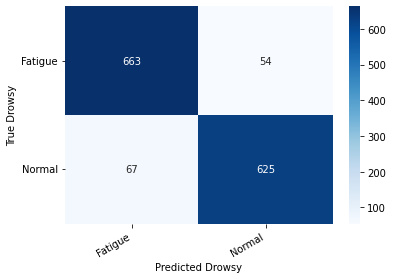

In [28]:
show_confusion_matrix(df_cm)